In [52]:
import pandas as pd
import seaborn as sns
import duckdb
import utils 
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import matplotlib.pyplot as plt



In [53]:
con = duckdb.connect("data.db")


In [54]:
oecd = con.sql("SELECT * FROM oecd").df() 
ecb = con.sql("SELECT * FROM ecb").df()         # Pandas DataFrame
eurostat = con.sql("SELECT * FROM eurostat").df()         # Pandas DataFrame
world_b = con.sql("SELECT * FROM world_bank").df()         # Pandas DataFrame


In [55]:
oecd.dtypes

DATE      object
GEO       object
LTIR     float64
STIR     float64
IIR      float64
CBAR     float64
UEMPR    float64
dtype: object

# **DATA PREPARATION**

- There is two different country abbrevation thorugh the data. In this section that is fixed to three letter abrevation and 
- the data merged via abbrevations and date 
- analyzed missing values and france selected as main data becasue it has the most non-null values

## Filtering

In [56]:
import pycountry

def convert_alpha2_to_alpha3(code):
    if not code or not isinstance(code, str):
        return code
    try:
        return pycountry.countries.get(alpha_2=code.upper()).alpha_3
    except:
        return code  # return original value if not ISO

    
eurostat['GEO'] = eurostat['GEO'].apply(convert_alpha2_to_alpha3)
eurostat['GEO'].unique()


array(['BRA', 'CAN', 'CHN', 'DEU', 'FRA', 'IDN', 'IND', 'ITA', 'JPN',
       'KOR', 'MEX', 'RUS', 'USA', 'ZAF', 'ARG', 'FIN', 'SAU', 'G20',
       'TUR', 'UK', 'BEL', 'EST', 'LTU', 'EA19', 'EU28', 'EU27_2020',
       'AUT', 'BGR', 'CHE', 'CYP', 'CZE', 'DNK', 'EA20', 'EL', 'ESP',
       'HRV', 'HUN', 'IRL', 'LUX', 'LVA', 'MNE', 'MLT', 'NLD', 'NOR',
       'POL', 'PRT', 'ROU', 'SRB', 'SVN', 'SVK', 'ALB', 'BIH', 'MKD',
       'SWE'], dtype=object)

In [57]:
import pandas as pd

def compare_columns(df1, df2, column_name):
    """
    Compare columns between two DataFrames and print common and uncommon columns.

    Parameters:
    - df1, df2: pandas DataFrames to compare
    """
    cols1 = set(df1[column_name])
    cols2 = set(df2[column_name])

    common = cols1 & cols2
    only_in_df1 = cols1 - cols2
    only_in_df2 = cols2 - cols1

    print("✅ Common columns:")
    print(sorted(common))
    print("\n🟥 Only in first DataFrame:")
    print(sorted(only_in_df1))
    print("\n🟦 Only in second DataFrame:")
    print(sorted(only_in_df2))

    return {
        "common": common,
        "only_in_df1": only_in_df1,
        "only_in_df2": only_in_df2
    }


In [58]:
col_names = compare_columns(oecd,eurostat,"GEO")

✅ Common columns:
['AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHN', 'CZE', 'DEU', 'DNK', 'EA19', 'EA20', 'ESP', 'EST', 'EU27_2020', 'FIN', 'FRA', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF']

🟥 Only in first DataFrame:
['A5M', 'AUS', 'CHL', 'COL', 'CRI', 'G7', 'GBR', 'GRC', 'ISL', 'ISR', 'NZL', 'OECD', 'OECDE', 'OECDXEA']

🟦 Only in second DataFrame:
['ALB', 'ARG', 'BIH', 'CYP', 'EL', 'EU28', 'G20', 'MKD', 'MLT', 'MNE', 'SAU', 'SRB', 'UK']


In [59]:
def filter_geo(df, geo):
    """
    Filters a DataFrame by one or more GEO codes.

    Parameters:
    - df: pandas DataFrame
    - geo: a single GEO string or a list of GEO strings

    Returns:
    - Filtered DataFrame
    """
    if isinstance(geo, (list, tuple, set)):
        return df[df["GEO"].isin(geo)]
    else:
        return df[df["GEO"] == geo]


In [60]:
import pandas as pd

def null_counts_by_category(df, category_col, date_col='DATE'):
    """
    Calculates number of nulls and percentage of nulls in each column,
    grouped by values in a category column.

    Parameters:
    - df: pandas DataFrame
    - category_col: column name to group by (as string)
    - date_col: column used to count total entries per category (default='DATE')

    Returns:
    - DataFrame: index = category values, columns = original columns (with count and percentage),
                 plus 'avg_perct' column, sorted by 'avg_perct'.
    """
    if category_col not in df.columns:
        raise ValueError(f"Column '{category_col}' not found in DataFrame.")

    # Count unique occurrences for each category (denominator for %)
    total_counts = df.groupby(category_col)[date_col].nunique()

    # Count nulls
    null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())
    null_counts = null_counts.drop(columns=[category_col], errors="ignore")

    # Calculate percentage of nulls for each column
    percentage_nulls = null_counts.div(total_counts, axis=0) * 100
    percentage_nulls = percentage_nulls.round(2).astype(str) + '%'

    # Calculate average percentage per row (as float)
    avg_perct = null_counts.div(total_counts, axis=0).mean(axis=1) * 100

    # Combine counts and percentages with avg_perct
    result = pd.concat([null_counts, percentage_nulls.add_suffix('_%')], axis=1)
    result['avg_perct'] = avg_perct.round(2)

    # Sort by average percentage
    result = result.sort_values(by='avg_perct')

    return result

In [61]:
null_counts_by_category(filter_geo(oecd,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


,DATE,LTIR,STIR,IIR,CBAR,UEMPR,DATE_%,LTIR_%,STIR_%,IIR_%,CBAR_%,UEMPR_%,avg_perct
GEO,,,,,,,,,,,,,
LTU,0,33,9,9,38,1,0.0%,10.22%,2.79%,2.79%,11.76%,0.31%,4.64
CZE,0,87,0,0,25,1,0.0%,22.54%,0.0%,0.0%,6.48%,0.26%,4.88
USA,0,0,135,15,82,21,0.0%,0.0%,15.64%,1.74%,9.5%,2.43%,4.89
SVK,0,58,5,0,42,27,0.0%,16.48%,1.42%,0.0%,11.93%,7.67%,6.25
FIN,0,13,0,144,11,13,0.0%,2.84%,0.0%,31.44%,2.4%,2.84%,6.59
HUN,0,97,28,12,26,61,0.0%,23.66%,6.83%,2.93%,6.34%,14.88%,9.11
KOR,0,129,12,12,108,0,0.0%,30.57%,2.84%,2.84%,25.59%,0.0%,10.31
CAN,0,0,12,240,301,0,0.0%,0.0%,1.43%,28.5%,35.75%,0.0%,10.95
ESP,0,79,43,0,158,155,0.0%,12.72%,6.92%,0.0%,25.44%,24.96%,11.67


In [62]:
null_counts_by_category(filter_geo(eurostat,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


,DATE,Retail_Volume,CPI,DATE_%,Retail_Volume_%,CPI_%,avg_perct
GEO,,,,,,,
DEU,0,2,0,0.0%,0.53%,0.0%,0.18
EU27_2020,0,2,0,0.0%,0.66%,0.0%,0.22
FRA,0,62,0,0.0%,16.58%,0.0%,5.53
ITA,0,74,0,0.0%,19.79%,0.0%,6.60
TUR,0,168,0,0.0%,48.28%,0.0%,16.09
KOR,0,374,0,0.0%,100.0%,0.0%,33.33
LTU,0,0,324,0.0%,0.0%,100.0%,33.33
LUX,0,0,300,0.0%,0.0%,100.0%,33.33
LVA,0,0,300,0.0%,0.0%,100.0%,33.33


In [63]:

df_merged_0 = filter_geo(eurostat,["FRA"]).merge(filter_geo(oecd,["FRA"]), on="DATE", how="outer")
df_merged_0

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR
0,1955-01,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN
1,1955-02,NaN,NaN,NaN,FRA,NaN,NaN,3.250000,NaN,NaN
2,1955-03,NaN,NaN,NaN,FRA,NaN,NaN,3.280000,NaN,NaN
3,1955-04,NaN,NaN,NaN,FRA,NaN,NaN,3.230000,NaN,NaN
4,1955-05,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
837,2024-10,FRA,-0.5,0.3,FRA,2.99,3.166609,3.371394,-0.154174,7.3
838,2024-11,FRA,0.2,-0.1,FRA,3.09,3.006762,3.164967,-0.386029,7.3
839,2024-12,FRA,-0.7,0.2,FRA,3.01,2.816091,3.102686,-0.372024,7.3
840,2025-01,FRA,-0.1,-0.2,FRA,3.32,2.703130,2.918839,0.575679,7.3


In [64]:
df_merged = df_merged_0.merge(world_b, on="DATE", how="outer")
df_merged

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR,POP_y
0,1955-01,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN,NaN
1,1955-02,NaN,NaN,NaN,FRA,NaN,NaN,3.250000,NaN,NaN,NaN
2,1955-03,NaN,NaN,NaN,FRA,NaN,NaN,3.280000,NaN,NaN,NaN
3,1955-04,NaN,NaN,NaN,FRA,NaN,NaN,3.230000,NaN,NaN,NaN
4,1955-05,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
837,2024-10,FRA,-0.5,0.3,FRA,2.99,3.166609,3.371394,-0.154174,7.3,NaN
838,2024-11,FRA,0.2,-0.1,FRA,3.09,3.006762,3.164967,-0.386029,7.3,NaN
839,2024-12,FRA,-0.7,0.2,FRA,3.01,2.816091,3.102686,-0.372024,7.3,NaN
840,2025-01,FRA,-0.1,-0.2,FRA,3.32,2.703130,2.918839,0.575679,7.3,NaN


### Handling missing values

In [65]:
import pandas as pd

# Assume df is your DataFrame and 'date' is your date column
df = df_merged.sort_values('DATE').reset_index(drop=True)  # Make sure it's sorted by date
# Identify numeric columns (excluding date)
numeric_cols = df.select_dtypes(include='number').columns

# Create a mask where all numeric values are NaN
all_nan_mask = df[numeric_cols].isnull().any(axis=1)
# Find first and last index where not all numeric values are NaN
first_valid_idx = df[~all_nan_mask].index[0]
last_valid_idx = df[~all_nan_mask].index[-1]

# Trim DataFrame from first to last valid index
df_trimmed = df.loc[first_valid_idx:last_valid_idx].copy()

# Fill missing values between using interpolation (or any other method)
df_filled = df_trimmed.copy()
df_filled[numeric_cols] = df_trimmed[numeric_cols].interpolate(method='linear')

# Optional: fill remaining nulls if interpolation didn't cover all
df_filled[numeric_cols] = df_filled[numeric_cols].fillna(method='bfill').fillna(method='ffill')


/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/2430720086.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[numeric_cols] = df_filled[numeric_cols].fillna(method='bfill').fillna(method='ffill')


In [66]:
df_filled

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR,POP_y
529,1999-02,FRA,1.7,0.4,FRA,3.9377,3.093400,3.118000,0.030459,12.0,6.053671e+07
530,1999-03,FRA,0.8,0.3,FRA,4.1367,3.046696,2.925200,-0.182699,11.8,6.057143e+07
531,1999-04,FRA,-0.4,0.3,FRA,3.9893,2.696455,2.709100,-0.091516,11.7,6.060615e+07
532,1999-05,FRA,0.7,0.0,FRA,4.1686,2.578952,2.551000,0.030533,11.5,6.064088e+07
533,1999-06,FRA,0.0,0.0,FRA,4.4893,2.626682,2.563200,0.137358,11.4,6.067560e+07
...,...,...,...,...,...,...,...,...,...,...,...
811,2022-08,FRA,1.3,0.5,FRA,1.6900,0.394739,-0.094652,0.454176,7.2,6.806502e+07
812,2022-09,FRA,1.9,-0.5,FRA,2.4100,1.010864,0.254584,-0.545665,7.1,6.806502e+07
813,2022-10,FRA,-1.6,1.2,FRA,2.7700,1.427667,0.655379,0.250815,7.2,6.806502e+07
814,2022-11,FRA,-1.0,0.4,FRA,2.5800,1.825227,1.266620,0.328371,7.2,6.806502e+07


## Stationarity

### Stationarity Checking

In [67]:
df_filled.set_index("DATE", inplace=True)

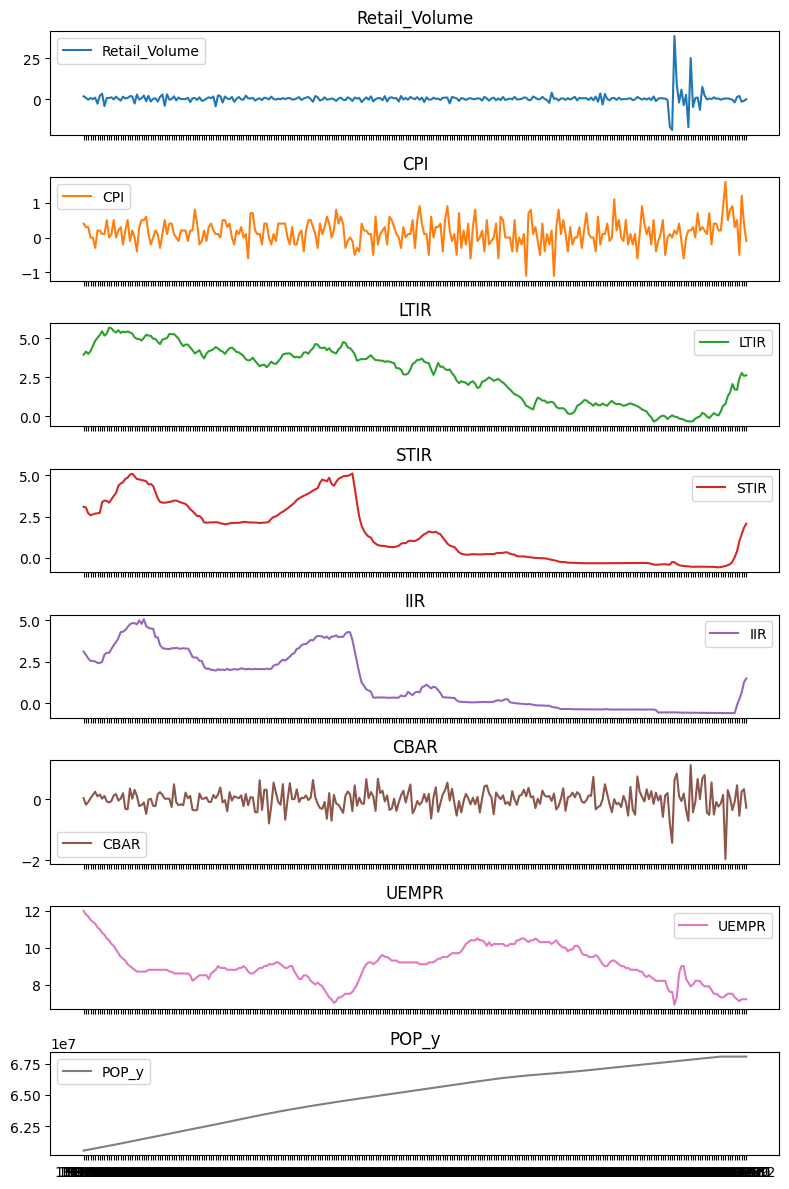

In [68]:
import matplotlib.pyplot as plt

# Select numeric columns
numeric_columns = df_filled.select_dtypes(include='number').columns

# Create subplots
fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(8, 12), sharex=True)

# Plot each numeric column
colors = plt.cm.tab10.colors  # Use a colormap for different colors
for i, column in enumerate(numeric_columns):
    axes[i].plot(df_filled.index, df_filled[column], label=column, color=colors[i % len(colors)])  # Use index instead of 'DATE'
    axes[i].set_title(column)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/960990963.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data, hist = False, kde = True,
/Users/emirysaglam/GitHub/Bitirme2/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/960990963.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in se

Lambda value used for Transformation: 7.903265568897737


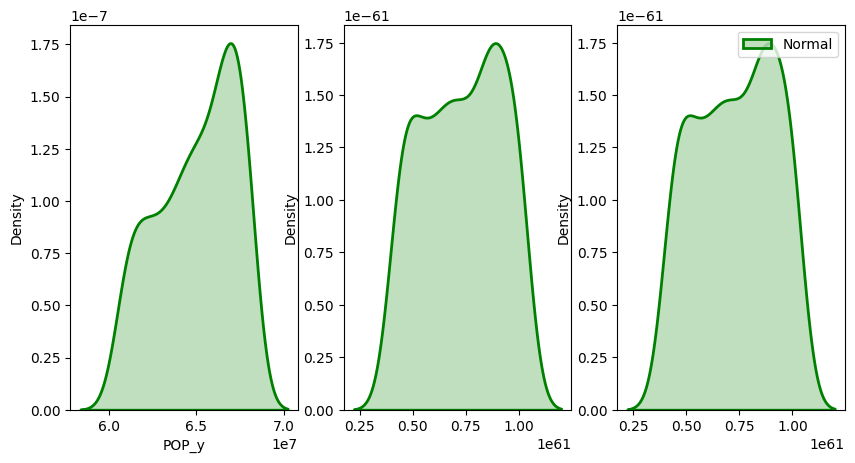

In [69]:
# Python3 code to show Box-cox Transformation 
# of non-normal data

# import modules
import numpy as np
from scipy import stats

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# generate non-normal data (exponential)
original_data = df_filled["POP_y"].copy()

# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(original_data)

fitted_data_2 = np.log(original_data)


# creating axes to draw plots
fig, ax = plt.subplots(1, 3)

# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(original_data, hist = False, kde = True,
			kde_kws = {'shade': True, 'linewidth': 2}, 
			label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_data, hist = False, kde = True,
			kde_kws = {'shade': True, 'linewidth': 2}, 
			label = "Normal", color ="green", ax = ax[1])

sns.distplot(fitted_data, hist = False, kde = True,
			kde_kws = {'shade': True, 'linewidth': 2}, 
			label = "Normal", color ="green", ax = ax[2])

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambda}")


In [70]:
df_filled["POP_y"] = fitted_data_2

populasyonu çıkardım çünkü log transformasyonla da düzgün bir hale gelmiyor, yıllık data olduğu için etkisini de ylık ayarlayamıyorum. Retail volume değişimine böleyim dedim olmadı

In [71]:
df_test = df_filled[['Retail_Volume', 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR',"POP_y"]].copy()

In [72]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import pandas as pd

def check_stationarity_extended(df, signif=0.05, regression='c'):
    """
    Check stationarity for each numeric column using multiple tests:
    ADF, KPSS, and PP.

    Parameters:
    - df: pandas DataFrame with numeric columns.
    - signif: significance level (default=0.05)
    - regression: type of regression (default='c' → constant only).
                  Options: 'c' (constant), 'ct' (constant + trend), 'nc' (no constant)

    Returns:
    - pd.DataFrame: one row per column, including test statistics, p-values, and stationarity results.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    results = []

    for col in df.select_dtypes(include='number').columns:
        row = {"Column": col}
        series = df[col].dropna()

        if len(series) < 10:
            row.update({
                "ADF_Stat": "Too short",
                "ADF_p-value": "Too short",
                "ADF_Stationary": "Too short",
                "KPSS_Stat": "Too short",
                "KPSS_p-value": "Too short",
                "KPSS_Stationary": "Too short",
                "PP_Stat": "Too short",
                "PP_p-value": "Too short",
                "PP_Stationary": "Too short"
            })
            results.append(row)
            continue

        # Augmented Dickey-Fuller
        try:
            adf_stat, adf_p, *_ = adfuller(series, regression=regression)
            row["ADF_Stat"] = adf_stat
            row["ADF_p-value"] = adf_p
            row["ADF_Stationary"] = adf_p < signif
        except Exception as e:
            row["ADF_Stat"] = f"Error: {str(e)}"
            row["ADF_p-value"] = f"Error: {str(e)}"
            row["ADF_Stationary"] = f"Error: {str(e)}"

        # KPSS (note: here null = stationary)
        try:
            kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
            row["KPSS_Stat"] = kpss_stat
            row["KPSS_p-value"] = kpss_p
            row["KPSS_Stationary"] = kpss_p > signif  # fail to reject ⇒ stationary
        except Exception as e:
            row["KPSS_Stat"] = f"Error: {str(e)}"
            row["KPSS_p-value"] = f"Error: {str(e)}"
            row["KPSS_Stationary"] = f"Error: {str(e)}"

        # Phillips-Perron
        try:
            pp_test = PhillipsPerron(series)
            row["PP_Stat"] = pp_test.stat
            row["PP_p-value"] = pp_test.pvalue
            row["PP_Stationary"] = pp_test.pvalue < signif
        except Exception as e:
            row["PP_Stat"] = f"Error: {str(e)}"
            row["PP_p-value"] = f"Error: {str(e)}"
            row["PP_Stationary"] = f"Error: {str(e)}"

        results.append(row)

    return pd.DataFrame(results)


In [73]:
check_stationarity_extended(df_test)

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/246

,Column,ADF_Stat,ADF_p-value,ADF_Stationary,KPSS_Stat,KPSS_p-value,KPSS_Stationary,PP_Stat,PP_p-value,PP_Stationary
0,Retail_Volume,-8.095452,1.342899e-12,True,0.149854,0.10,True,-31.845998,0.000000e+00,True
1,CPI,-1.700570,4.308189e-01,False,0.177164,0.10,True,-17.170662,6.746779e-30,True
2,LTIR,-1.280830,6.378965e-01,False,2.418885,0.01,False,-1.182403,6.811193e-01,False
3,STIR,-2.148515,2.254589e-01,False,2.066286,0.01,False,-1.675160,4.439543e-01,False
4,IIR,-1.708638,4.266675e-01,False,2.148818,0.01,False,-1.647035,4.585870e-01,False
5,CBAR,-5.948606,2.174082e-07,True,0.024523,0.10,True,-20.035241,0.000000e+00,True
6,UEMPR,-2.130598,2.323905e-01,False,0.304612,0.10,True,-2.677583,7.799839e-02,False
7,POP_y,-2.492573,1.172918e-01,False,2.653222,0.01,False,-11.225170,1.968757e-20,True


- Retail_Volume: ✅ Stationary (Strong evidence)
- CPI: ⚠️ Mixed (likely trend-stationary)
- LTIR: ❌ Not stationary
- STIR: ❌ Not stationary
- IIR: ❌ Not stationary
- CBAR: ✅ Stationary (Strong evidence)
- UEMPR: ⚠️ Mixed (inconclusive)
- POP_y: ❌ Not stationary




### ? Should I also check for joint stationarity

### Transformaiton to Make Data Stationary

#### Q-Q Test

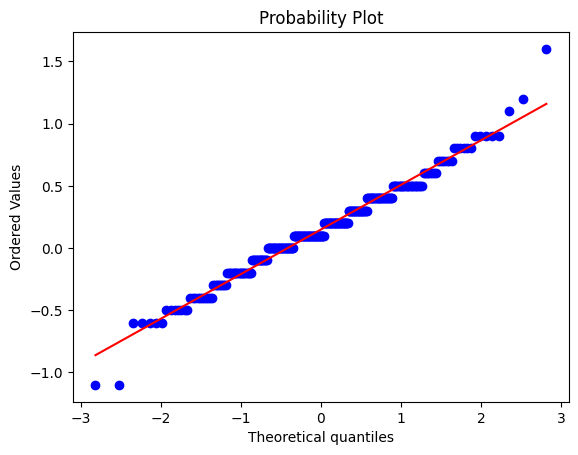

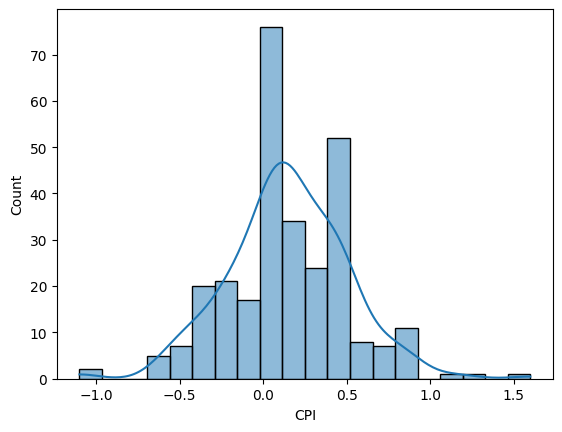

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

stats.probplot(df_test['CPI'], dist="norm", plot=plt)
plt.show()

sns.histplot(df_test['CPI'], kde=True)
plt.show()

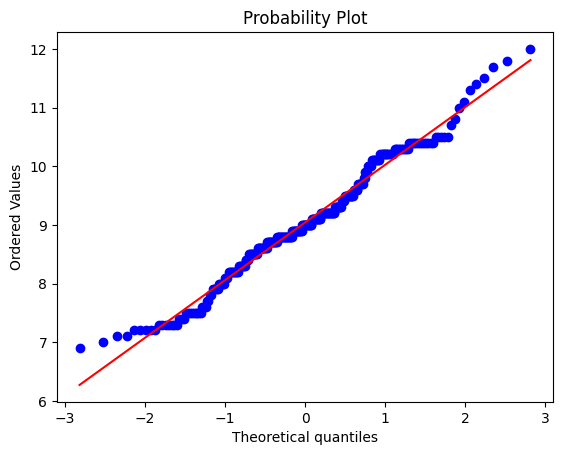

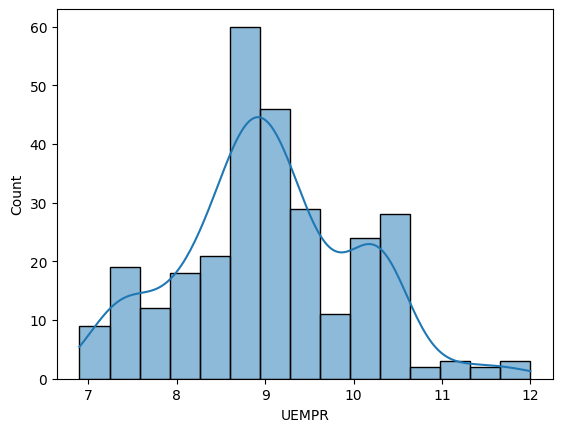

In [75]:
stats.probplot(df_test['UEMPR'], dist="norm", plot=plt)
plt.show()

sns.histplot(df_test['UEMPR'], kde=True)
plt.show()

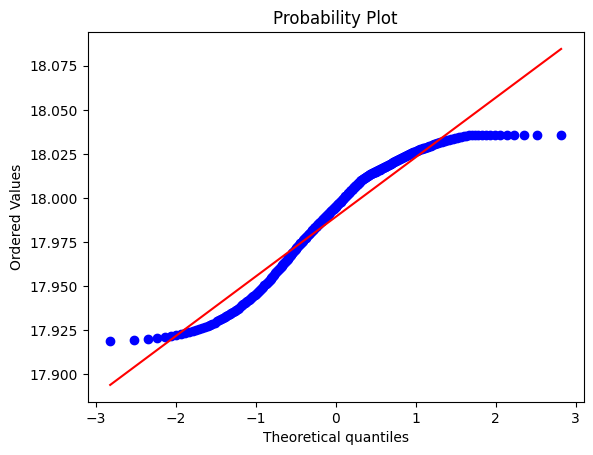

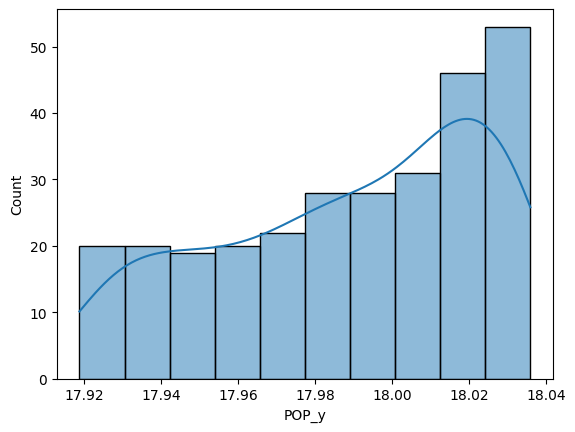

In [76]:
stats.probplot(df_test['POP_y'], dist="norm", plot=plt)
plt.show()

sns.histplot(df_test['POP_y'], kde=True)
plt.show()

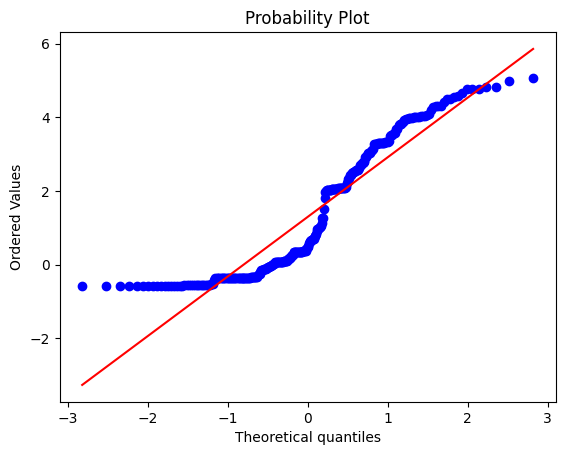

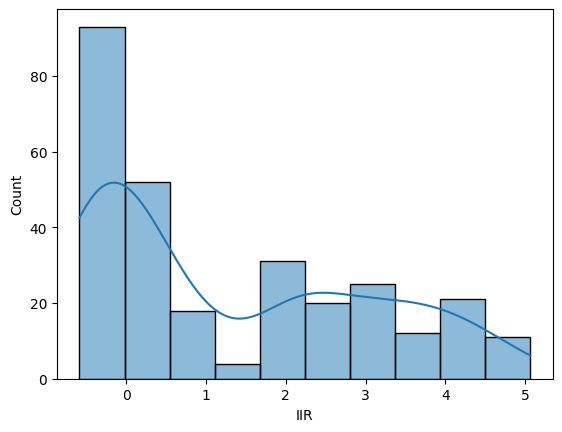

In [77]:

stats.probplot(df_test['IIR'], dist="norm", plot=plt)
plt.show()

sns.histplot(df_test['IIR'], kde=True)
plt.show()

Interest rates do not follow a normal distribution. Population and unemployment rates approximately follow a normal distribution. Consumer Price Index (CPI) is normally distributed.

#### ?? Mardia function 

In [78]:
import numpy as np
from typing import Tuple

## from https://github.com/quillan86/mvn-python/blob/master/mvn.py

def mardia_test(data: np.ndarray, cov: bool = True) -> Tuple[float, float, float, float]:
    """
    https://rdrr.io/cran/MVN/src/R/mvn.R
    https://stats.stackexchange.com/questions/317147/how-to-get-a-single-p-value-from-the-two-p-values-of-a-mardias-multinormality-t
    Mardia's multivariate skewness and kurtosis.
    Calculates the Mardia's multivariate skewness and kurtosis coefficients
    as well as their corresponding statistical test. For large sample size
    the multivariate skewness is asymptotically distributed as a Chi-square
    random variable; here it is corrected for small sample size. However,
    both uncorrected and corrected skewness statistic are presented. Likewise,
    the multivariate kurtosis it is distributed as a unit-normal.

     Syntax: function [Mskekur] = Mskekur(X,c,alpha)

     Inputs:
          X - multivariate data matrix [Size of matrix must be n(data)-by-p(variables)].
          cov - boolean to whether to normalize the covariance matrix by n (c=1[default]) or by n-1 (c~=1)

     Outputs:
          - skewness test statistic
          - kurtosis test statistic
          - significance value for skewness
          - significance value for kurtosis
    """
    n, p = data.shape

    # correct for small sample size
    small: bool = True if n < 20 else False

    if cov:
        S = ((n - 1)/n) * np.cov(data.T)
    else:
        S = np.cov(data.T)

    # calculate mean
    data_mean = data.mean(axis=0)
    # inverse - check if singular matrix
    try:
        iS = np.linalg.inv(S)
    except Exception as e:
        # print for now
        print(e)
        return 0.0, 0.0, 0.0, 0.0
    # squared-Mahalanobis' distances matrix
    D: np.ndarray = (data - data_mean) @ iS @ (data - data_mean).T
    # multivariate skewness coefficient
    g1p: float = np.sum(D**3)/n**2
    # multivariate kurtosis coefficient
    g2p: float = np.trace(D**2)/n
    # small sample correction
    k: float = ((p + 1)*(n + 1)*(n + 3))/(n*(((n + 1)*(p + 1)) - 6))
    # degrees of freedom
    df: float = (p * (p + 1) * (p + 2))/6

    if small:
        # skewness test statistic corrected for small sample: it approximates to a chi-square distribution
        g_skew = (n * g1p * k)/6
    else:
        # skewness test statistic:it approximates to a chi-square distribution
        g_skew = (n * g1p)/6

    # significance value associated to the skewness corrected for small sample
    p_skew: float = 1.0 - stats.chi2.cdf(g_skew, df)

    # kurtosis test statistic: it approximates to a unit-normal distribution
    g_kurt = (g2p - (p*(p + 2)))/(np.sqrt((8 * p * (p + 2))/n))
    # significance value associated to the kurtosis
    p_kurt: float = 2 * (1.0 - stats.norm.cdf(np.abs(g_kurt)))

    return g_skew, g_kurt, p_skew, p_kurt

mardia_test(df_test[[ 'CPI', 'UEMPR']].to_numpy(), cov=True)

(np.float64(3.7606169505051685),
 np.float64(2.4854068558475073),
 np.float64(0.43937101885846064),
 np.float64(0.012940344612128563))

#### ?? Transforming the Data

In [79]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox, chi2
from scipy.optimize import minimize
from statsmodels.tools.eval_measures import aic

def boxcox_log_likelihood(X, lambdas):
    """
    Computes the log-likelihood of the Box-Cox transformation for multivariate data.
    """
    n_obs, n_vars = X.shape
    transformed = np.zeros_like(X)
    log_likelihood = 0

    for j in range(n_vars):
        col = X[:, j]
        lam = lambdas[j]
        if np.any(col <= 0):
            raise ValueError("Box-Cox requires strictly positive data.")
        
        if np.isclose(lam, 0):
            transformed[:, j] = np.log(col)
        else:
            transformed[:, j] = (col**lam - 1) / lam
        log_likelihood += (lam - 1) * np.sum(np.log(col))
    
    cov = np.cov(transformed.T)
    sign, logdet = np.linalg.slogdet(cov)
    if sign != 1:
        return -np.inf
    log_likelihood -= 0.5 * n_obs * logdet
    return log_likelihood

def find_optimal_lambda(X):
    """
    Finds the optimal lambda vector that maximizes the multivariate Box-Cox log-likelihood.
    """
    n_vars = X.shape[1]
    bounds = [(-5, 5)] * n_vars
    init = np.ones(n_vars)

    result = minimize(
        lambda lam: -boxcox_log_likelihood(X, lam),
        x0=init,
        bounds=bounds,
        method='L-BFGS-B'
    )

    return result.x, -result.fun

def transform_data_with_lambda(X, lambdas):
    """
    Applies Box-Cox transformation with specific lambdas.
    """
    transformed = np.zeros_like(X)
    for j in range(X.shape[1]):
        col = X[:, j]
        lam = lambdas[j]
        if np.isclose(lam, 0):
            transformed[:, j] = np.log(col)
        else:
            transformed[:, j] = (col**lam - 1) / lam
    return transformed

def boxcox_joint_test(X, lambda_null=None, alpha=0.05):
    """
    Main function: test Box-Cox transformation for multivariate stationarity.
    """
    X = np.asarray(X)
    opt_lambda, lmax_star = find_optimal_lambda(X)

    if lambda_null is None:
        lambda_null = np.ones(X.shape[1])  # default: no transformation
    lmax_null = boxcox_log_likelihood(X, lambda_null)

    # Likelihood Ratio Test
    LK = 2 * (lmax_star - lmax_null)
    tau = chi2.ppf(1 - alpha, df=X.shape[1])
    reject = LK > tau

    transformed_data = transform_data_with_lambda(X, opt_lambda)

    return {
        "optimal_lambda": opt_lambda,
        "LK_stat": LK,
        "critical_value": tau,
        "reject_H0": reject,
        "transformed_data": transformed_data
    }


In [80]:
# df: a pandas DataFrame with only positive values
result = boxcox_joint_test(df_test[['UEMPR','POP_y']].values)

print("Optimal Lambda:", result["optimal_lambda"])
print("Reject Null Hypothesis:", result["reject_H0"])


Optimal Lambda: [0.3624391 5.       ]
Reject Null Hypothesis: False


In [81]:
['CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR','POP_y']

['CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR', 'POP_y']

#### Differencing

In [82]:
df_test

,Retail_Volume,CPI,LTIR,STIR,IIR,CBAR,UEMPR,POP_y
DATE,,,,,,,,
1999-02,1.7,0.4,3.9377,3.093400,3.118000,0.030459,12.0,17.918760
1999-03,0.8,0.3,4.1367,3.046696,2.925200,-0.182699,11.8,17.919334
1999-04,-0.4,0.3,3.9893,2.696455,2.709100,-0.091516,11.7,17.919907
1999-05,0.7,0.0,4.1686,2.578952,2.551000,0.030533,11.5,17.920480
1999-06,0.0,0.0,4.4893,2.626682,2.563200,0.137358,11.4,17.921052
...,...,...,...,...,...,...,...,...
2022-08,1.3,0.5,1.6900,0.394739,-0.094652,0.454176,7.2,18.035974
2022-09,1.9,-0.5,2.4100,1.010864,0.254584,-0.545665,7.1,18.035974
2022-10,-1.6,1.2,2.7700,1.427667,0.655379,0.250815,7.2,18.035974


In [83]:
diff_df = df_test[['CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR',"POP_y"]].diff().dropna()[:-12]
diff_df

,CPI,LTIR,STIR,IIR,UEMPR,POP_y
DATE,,,,,,
1999-03,-0.1,0.1990,-0.046704,-0.192800,-0.2,0.000573
1999-04,0.0,-0.1474,-0.350241,-0.216100,-0.1,0.000573
1999-05,-0.3,0.1793,-0.117503,-0.158100,-0.2,0.000573
1999-06,0.0,0.3207,0.047730,0.012200,-0.1,0.000572
1999-07,-0.3,0.3327,0.049773,-0.042300,-0.1,0.000572
...,...,...,...,...,...,...
2021-08,0.6,-0.1100,-0.002773,-0.001578,0.0,0.000272
2021-09,-0.9,0.1600,0.002545,-0.001260,-0.2,0.000272
2021-10,0.6,0.1600,-0.004764,-0.001053,-0.2,0.000272


In [84]:
check_stationarity_extended(diff_df)

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/2469383986.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_4948/246

,Column,ADF_Stat,ADF_p-value,ADF_Stationary,KPSS_Stat,KPSS_p-value,KPSS_Stationary,PP_Stat,PP_p-value,PP_Stationary
0,CPI,-10.226986,5.146020e-18,True,0.097265,0.10,True,-71.868703,0.000000e+00,True
1,LTIR,-11.330934,1.113235e-20,True,0.128146,0.10,True,-11.946229,4.423729e-22,True
2,STIR,-5.023723,1.991492e-05,True,0.055284,0.10,True,-7.787267,8.116915e-12,True
3,IIR,-4.847747,4.403136e-05,True,0.048147,0.10,True,-10.971506,7.859127e-20,True
4,UEMPR,-4.721260,7.674530e-05,True,0.307452,0.10,True,-11.241511,1.802254e-20,True
5,POP_y,-1.273814,6.410659e-01,False,2.388729,0.01,False,-0.700300,8.466719e-01,False


In [85]:
diff_df

,CPI,LTIR,STIR,IIR,UEMPR,POP_y
DATE,,,,,,
1999-03,-0.1,0.1990,-0.046704,-0.192800,-0.2,0.000573
1999-04,0.0,-0.1474,-0.350241,-0.216100,-0.1,0.000573
1999-05,-0.3,0.1793,-0.117503,-0.158100,-0.2,0.000573
1999-06,0.0,0.3207,0.047730,0.012200,-0.1,0.000572
1999-07,-0.3,0.3327,0.049773,-0.042300,-0.1,0.000572
...,...,...,...,...,...,...
2021-08,0.6,-0.1100,-0.002773,-0.001578,0.0,0.000272
2021-09,-0.9,0.1600,0.002545,-0.001260,-0.2,0.000272
2021-10,0.6,0.1600,-0.004764,-0.001053,-0.2,0.000272


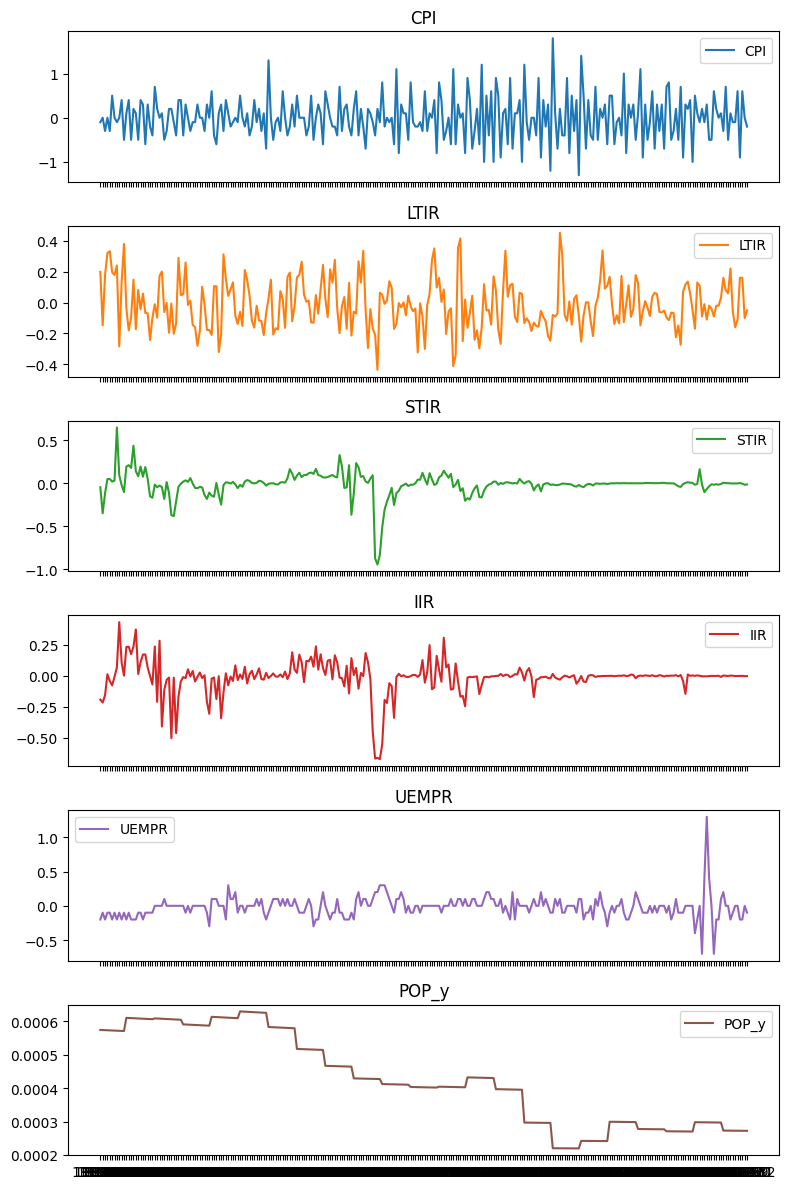

In [86]:
import matplotlib.pyplot as plt

# Select numeric columns

# Create subplots
fig, axes = plt.subplots(len(diff_df.columns), 1, figsize=(8, 12), sharex=True)

# Plot each numeric column
colors = plt.cm.tab10.colors  # Use a colormap for different colors
for i, column in enumerate(diff_df.columns):
    axes[i].plot(diff_df.index, diff_df[column], label=column, color=colors[i % len(colors)])
    axes[i].set_title(column)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# **CCF and PCCF**

In [87]:
df_stationary = df_test[["Retail_Volume", "CBAR"]].merge(diff_df, left_index=True, right_index=True).dropna()

In [88]:
df_stationary

,Retail_Volume,CBAR,CPI,LTIR,STIR,IIR,UEMPR,POP_y
DATE,,,,,,,,
1999-03,0.8,-0.182699,-0.1,0.1990,-0.046704,-0.192800,-0.2,0.000573
1999-04,-0.4,-0.091516,0.0,-0.1474,-0.350241,-0.216100,-0.1,0.000573
1999-05,0.7,0.030533,-0.3,0.1793,-0.117503,-0.158100,-0.2,0.000573
1999-06,0.0,0.137358,0.0,0.3207,0.047730,0.012200,-0.1,0.000572
1999-07,0.9,0.243858,-0.3,0.3327,0.049773,-0.042300,-0.1,0.000572
...,...,...,...,...,...,...,...,...
2021-08,0.4,-0.517331,0.6,-0.1100,-0.002773,-0.001578,0.0,0.000272
2021-09,0.0,0.550611,-0.9,0.1600,0.002545,-0.001260,-0.2,0.000272
2021-10,1.1,-0.501962,0.6,0.1600,-0.004764,-0.001053,-0.2,0.000272


## CCF

In [89]:
from statsmodels.tsa.stattools import ccf 

def top_ccf_values(series1, series2, top_n=3):
    ccf_values = ccf(series1, series2)
    abs_values_with_index = [(i, val) for i, val in enumerate(ccf_values)]
    top_values = sorted(abs_values_with_index, key=lambda x: abs(x[1]), reverse=True)[:top_n]
    
    print("Top CCF Values:")
    for idx, value in top_values:
        print(f"Index: {idx}, Value: {value}")

    return top_values



In [90]:
df_stationary.shape

(274, 8)

In [91]:
df_stationary

,Retail_Volume,CBAR,CPI,LTIR,STIR,IIR,UEMPR,POP_y
DATE,,,,,,,,
1999-03,0.8,-0.182699,-0.1,0.1990,-0.046704,-0.192800,-0.2,0.000573
1999-04,-0.4,-0.091516,0.0,-0.1474,-0.350241,-0.216100,-0.1,0.000573
1999-05,0.7,0.030533,-0.3,0.1793,-0.117503,-0.158100,-0.2,0.000573
1999-06,0.0,0.137358,0.0,0.3207,0.047730,0.012200,-0.1,0.000572
1999-07,0.9,0.243858,-0.3,0.3327,0.049773,-0.042300,-0.1,0.000572
...,...,...,...,...,...,...,...,...
2021-08,0.4,-0.517331,0.6,-0.1100,-0.002773,-0.001578,0.0,0.000272
2021-09,0.0,0.550611,-0.9,0.1600,0.002545,-0.001260,-0.2,0.000272
2021-10,1.1,-0.501962,0.6,0.1600,-0.004764,-0.001053,-0.2,0.000272


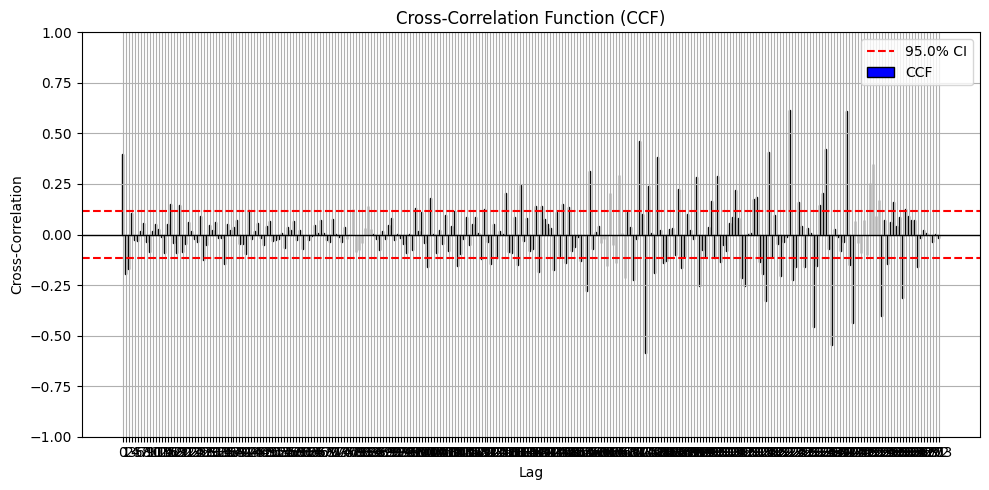

Top CCF Values:
Index: 223, Value: 0.6177866506402708
Index: 242, Value: 0.6087085083121506
Index: 175, Value: -0.5865243652190315


[(223, np.float64(0.6177866506402708)),
 (242, np.float64(0.6087085083121506)),
 (175, np.float64(-0.5865243652190315))]

In [92]:

utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary['CBAR'],274)

# Example usage:
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['CBAR'])

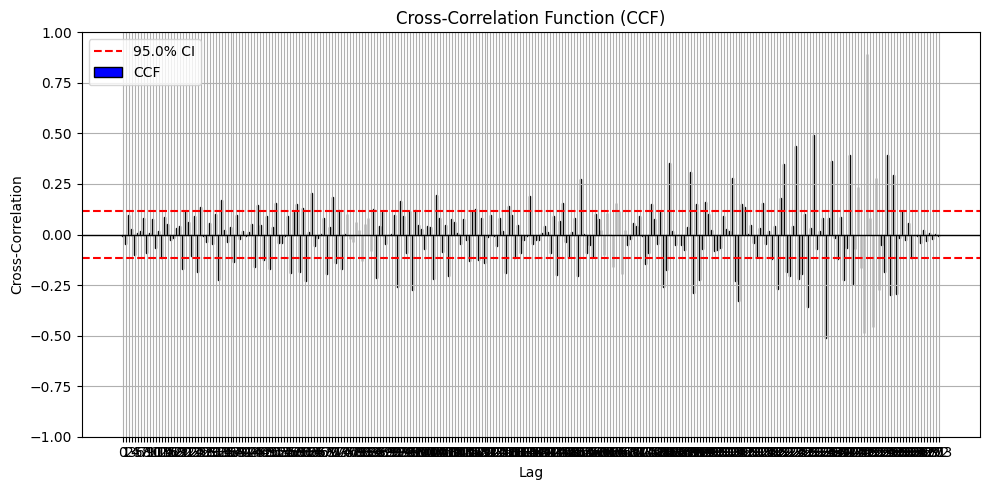

Top CCF Values:
Index: 249, Value: 0.89424311851819
Index: 235, Value: -0.510049472688934
Index: 231, Value: 0.4906860095667627


[(249, np.float64(0.89424311851819)),
 (235, np.float64(-0.510049472688934)),
 (231, np.float64(0.4906860095667627))]

In [93]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["CPI"],nlags=274)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['CPI'])

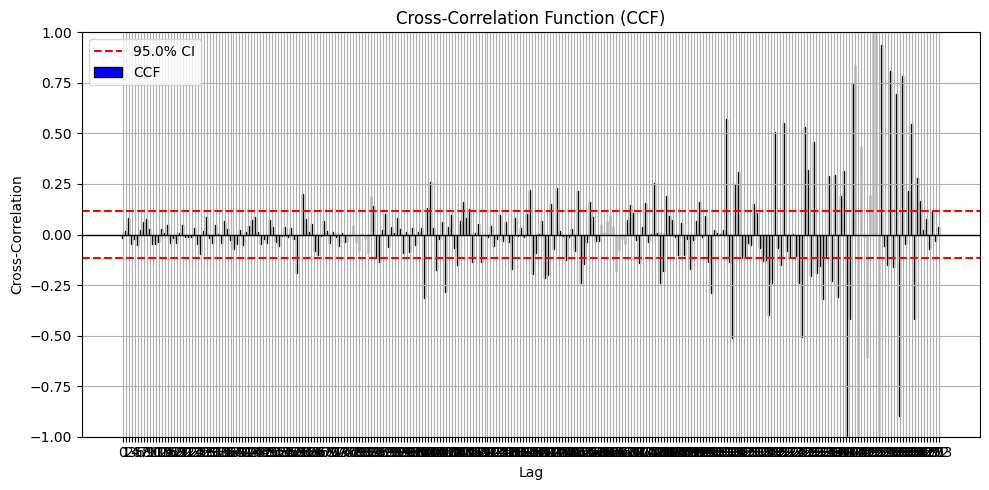

Top CCF Values:
Index: 246, Value: -1.5964550577036476
Index: 253, Value: -1.4590878789940374
Index: 251, Value: 1.370444671032463


[(246, np.float64(-1.5964550577036476)),
 (253, np.float64(-1.4590878789940374)),
 (251, np.float64(1.370444671032463))]

In [94]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["LTIR"],nlags=274)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['LTIR'])

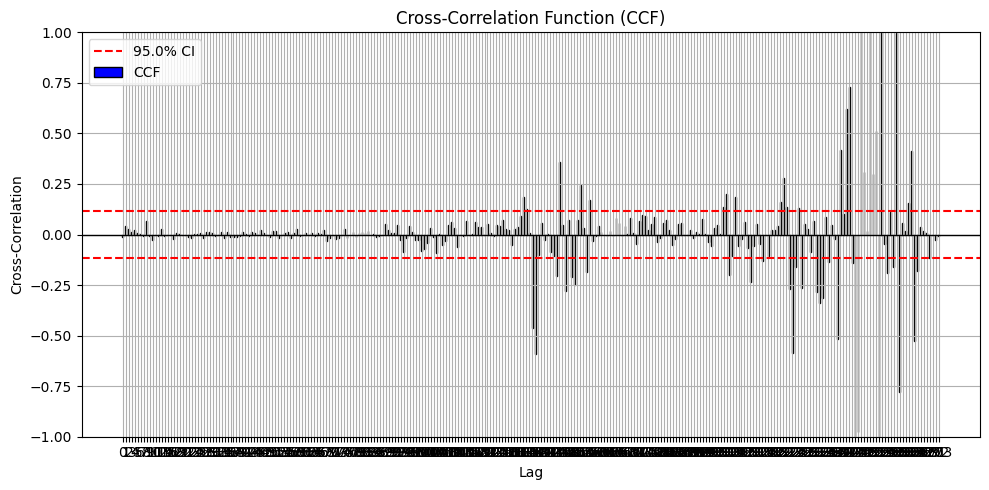

Top CCF Values:
Index: 247, Value: 2.286099484012077
Index: 253, Value: -1.9369564308370675
Index: 254, Value: 1.144106851749603


[(247, np.float64(2.286099484012077)),
 (253, np.float64(-1.9369564308370675)),
 (254, np.float64(1.144106851749603))]

In [95]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["STIR"],nlags=274)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['STIR'])

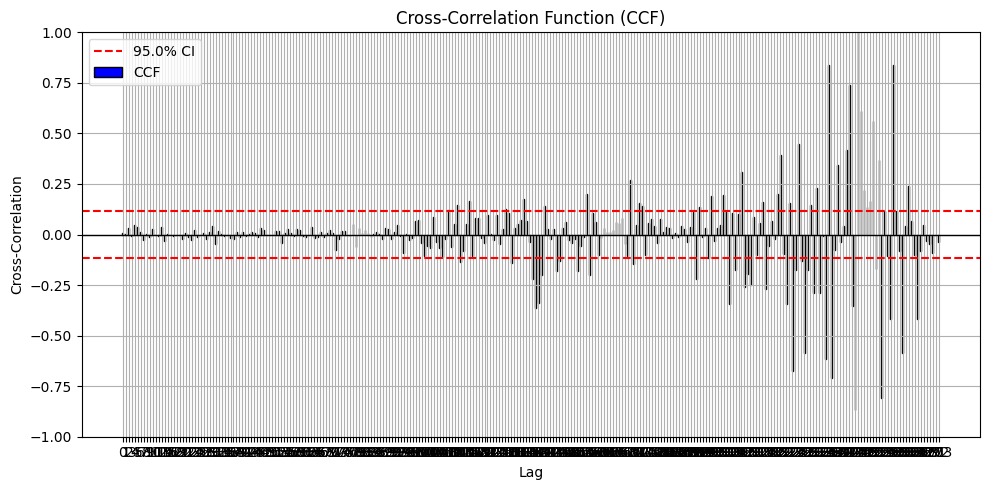

Top CCF Values:
Index: 246, Value: 1.6428179064787116
Index: 245, Value: -0.8675845386623351
Index: 236, Value: 0.8397602544308416


[(246, np.float64(1.6428179064787116)),
 (245, np.float64(-0.8675845386623351)),
 (236, np.float64(0.8397602544308416))]

In [96]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["IIR"],nlags=274)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['IIR'])

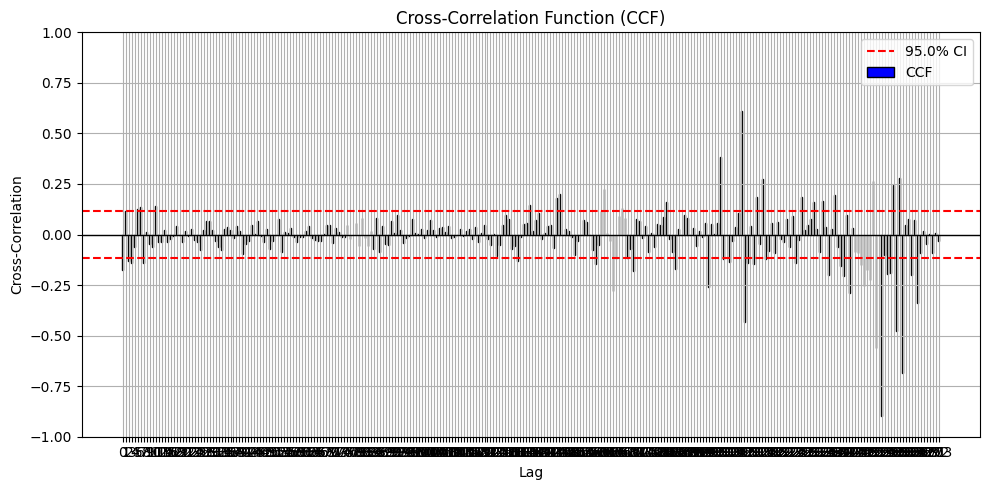

Top CCF Values:
Index: 254, Value: -0.8987670505672283
Index: 261, Value: -0.6839756162807822
Index: 207, Value: 0.6117179932462576


[(254, np.float64(-0.8987670505672283)),
 (261, np.float64(-0.6839756162807822)),
 (207, np.float64(0.6117179932462576))]

In [97]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["UEMPR"],nlags=274)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['UEMPR'])

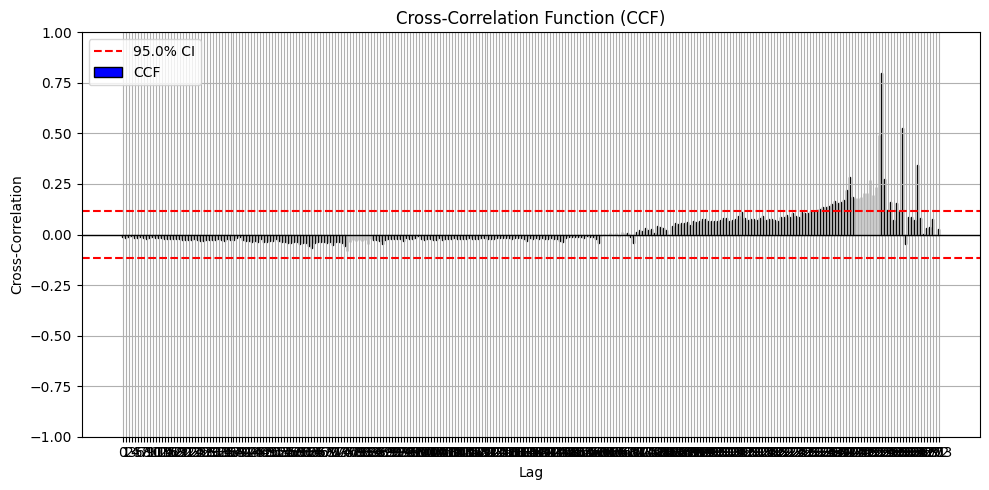

Top CCF Values:
Index: 254, Value: 0.8004178547066829
Index: 261, Value: 0.5245622340043662
Index: 253, Value: 0.49121274486463246


[(254, np.float64(0.8004178547066829)),
 (261, np.float64(0.5245622340043662)),
 (253, np.float64(0.49121274486463246))]

In [98]:
utils.ccf_plot(df_stationary["Retail_Volume"],df_stationary["POP_y"],nlags=274)
top_ccf_values(df_stationary["Retail_Volume"], df_stationary['POP_y'])


In [99]:
import pandas as pd
import numpy as np

cbr = ccf(df_stationary["Retail_Volume"], df_stationary['CBAR'])
cpi = ccf(df_stationary["Retail_Volume"], df_stationary['CPI'])
ltir = ccf(df_stationary["Retail_Volume"], df_stationary['LTIR'])
stir = ccf(df_stationary["Retail_Volume"], df_stationary['STIR'])
iir = ccf(df_stationary["Retail_Volume"], df_stationary['IIR'])
uempr = ccf(df_stationary["Retail_Volume"], df_stationary['UEMPR'])


# Create a DataFrame from the absolute values of the arrays
df_abs_values = pd.DataFrame({
    'CBAR': np.abs(cbr),
    'CPI': np.abs(cpi),
    # 'LTIR': np.abs(ltir),
    # 'STIR': np.abs(stir),
    # 'IIR': np.abs(iir),
    'UEMPR': np.abs(uempr)
})




df_abs_values['Average'] = df_abs_values.mean(axis=1)
filtered_df = df_abs_values[df_abs_values.drop(columns=['Average']).ge(0.1).any(axis=1)]
filtered_df.sort_values(by='Average', ascending=False).head(10)



,CBAR,CPI,UEMPR,Average
254,0.402515,0.051948,0.898767,0.451077
249,0.103307,0.894243,0.176447,0.391332
261,0.314478,0.114854,0.683976,0.371103
231,0.459448,0.490686,0.159576,0.369903
251,0.348466,0.456140,0.263199,0.355935
207,0.213902,0.149252,0.611718,0.324957
235,0.422147,0.510049,0.037153,0.323117
237,0.544735,0.363107,0.028719,0.312187
252,0.090656,0.278768,0.558971,0.309465
223,0.617787,0.202923,0.061929,0.294213


## exploring crysis periods

March 2020 – June 2020

September 2008 - March 2009

In [100]:
from scipy.stats import norm

import pandas as pd

# Creating the data for the table
data = {
    "Crisis Interval": [(90,108), (123,153), (224,240), (60,84),
                      (132,156), (72,96), (12,24), (132,156), (60,72), (132,153)],
    "Crisis Pair": ["GFC - Dot-com", "COVID - GFC", "COVID - Dot-com", "GFC - Eurozone", 
                    "COVID - Eurozone", "Dot-com - Eurozone", "GFC - Yellow Vests", 
                    "COVID - Yellow Vests", "Dot-com - Yellow Vests", "Eurozone - Yellow Vests"],
}



def ccf_plot_custom(x, y, nlags=20, alpha=0.05,intervals=None,text=None):
    """
    Plot the Cross-Correlation Function (CCF) between two time series.

    Parameters:
    -----------
    x : array-like
        First time series.
    y : array-like
        Second time series.
    nlags : int
        Number of lags to compute.
    alpha : float
        Significance level for confidence intervals.

    Returns:
    --------
    Displays a CCF plot.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Calculate CCF values
    ccf_vals = ccf(x, y, adjusted=True )[:nlags]  # extract only the values

    # Calculate standard error
    n = len(x)
    std_error = 1 / np.sqrt(n)

    # Calculate the z-score corresponding to the alpha value (for confidence interval)
    z_score = norm.ppf(1 - alpha / 2)  # Two-tailed test: 1 - alpha / 2

    # Calculate confidence interval
    confint_upper = std_error * z_score
    confint_lower = -std_error * z_score

    # Plot
    lags = np.arange(nlags)
    plt.figure(figsize=(10, 4))
    plt.bar(lags, ccf_vals, width=0.3, color='blue', edgecolor='black',label='CCF')

    # Plot confidence intervals
    plt.axhline(y=0, color='black', linewidth=1)
    plt.axhline(y=confint_upper, color='red', linestyle='dashed', label=f'{100*(1-alpha)}% CI')
    plt.axhline(y=confint_lower, color='red', linestyle='dashed')

    # Set fixed y-axis limits from -1 to 1
    plt.ylim(-1, 1)

    plt.xlabel("Lag")
    plt.ylabel("Cross-Correlation")
    plt.title("Cross-Correlation Function (CCF)")
    
    plt.xticks(np.arange(9, 274, 12))

    yy = np.linspace(-10, 10, 100)

    x1 = np.full_like(yy, intervals[0] )  # Line at y=2
    x2 = np.full_like(yy, intervals[1])  # Line at y=6
    # Fill between the two lines
    plt.fill_betweenx(yy, x1, x2, color='skyblue', alpha=0.5)
    plt.text(intervals[0],0.80,s=text, fontsize=9, ha='left')


    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    

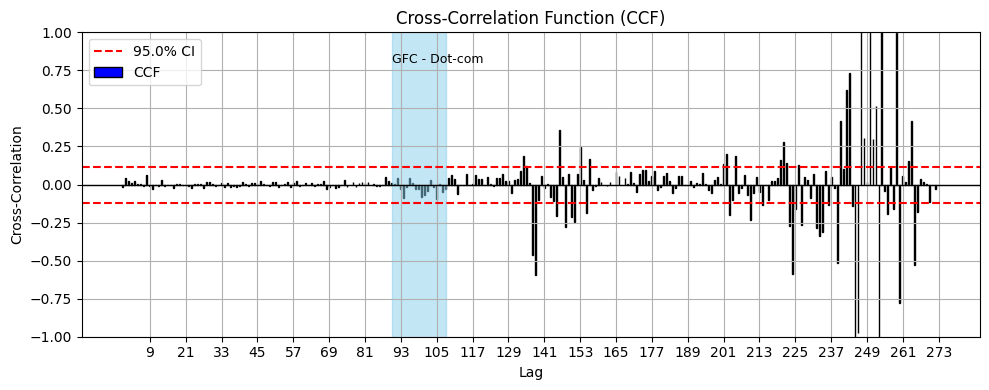

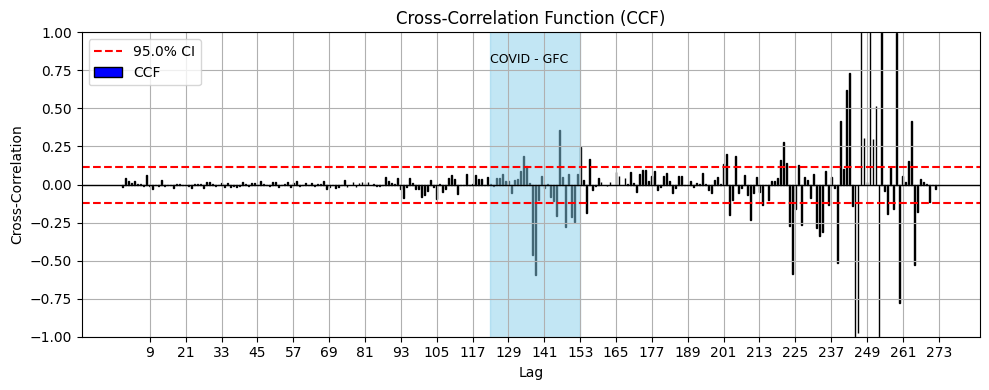

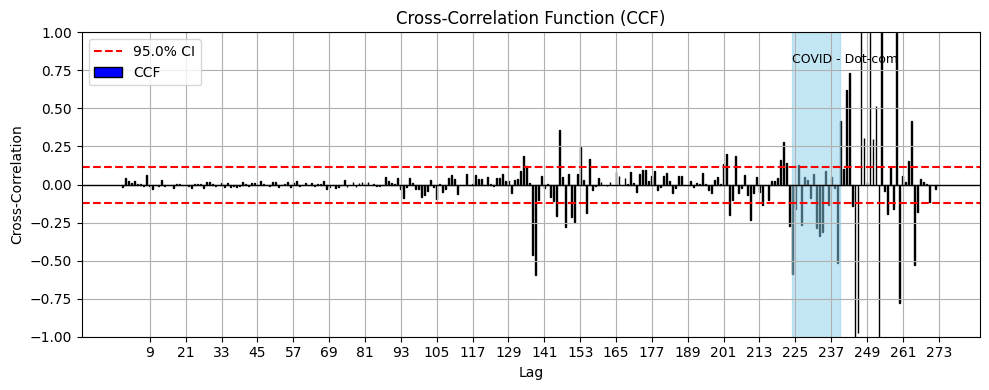

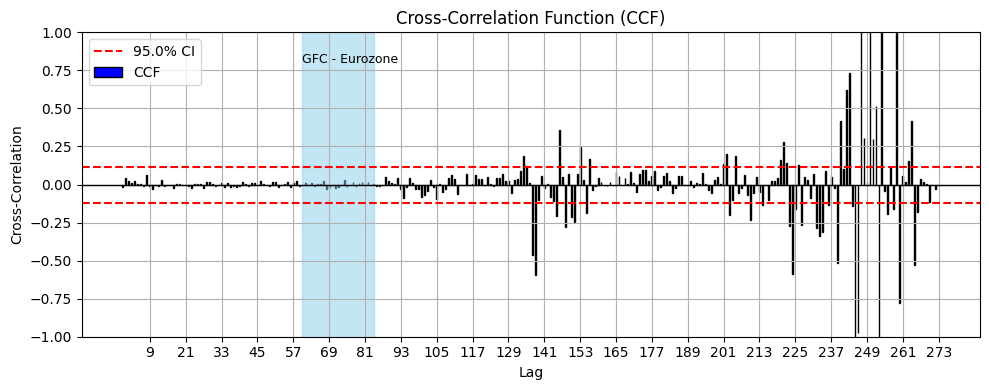

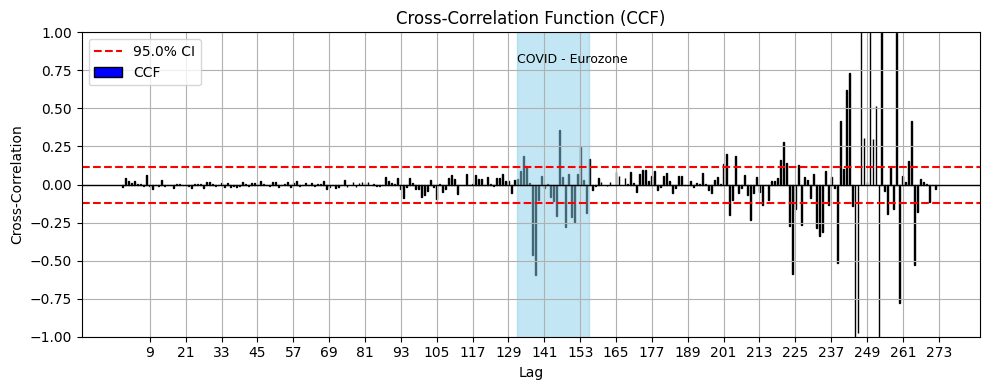

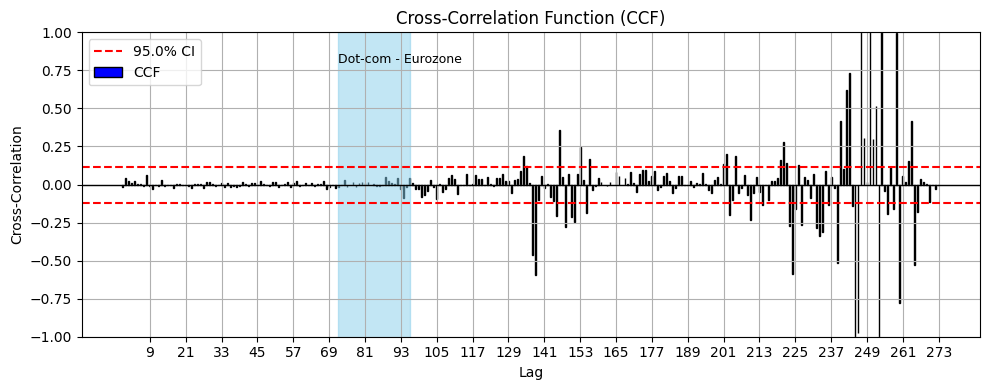

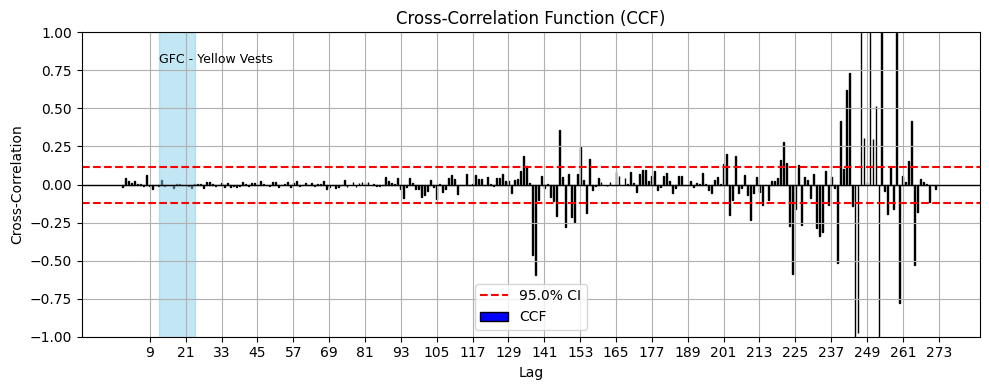

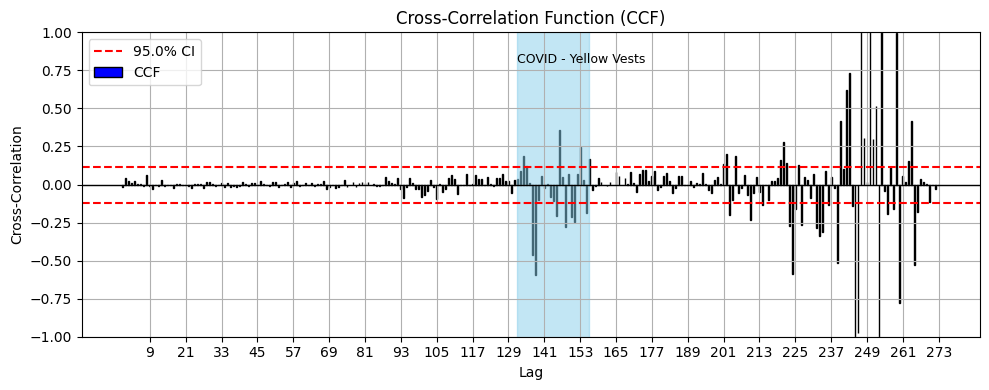

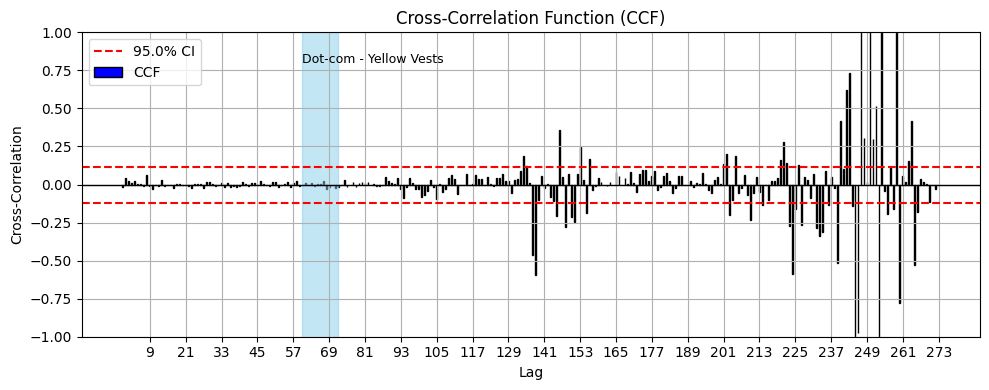

In [101]:
for i in range(9):
    ccf_plot_custom(df_stationary["Retail_Volume"],df_stationary['STIR'],274,intervals=data['Crisis Interval'][i],text=data['Crisis Pair'][i])

In [102]:
import pandas as pd

def crysis_periods_data(col_x,col_y,df_stationary):
    # Assuming df is your original DataFrame
    # Define the crisis intervals
    crisis_periods_fixed = {
        "dotcom": "2000-01",
        "gfc": "2007-10",
        "eurocrisis": "2010-01",
        "yellowvests": "2018-11",
        "covid": "2020-03"
    }

    df = df_stationary.copy()

    # Convert index to datetime if not already
    df.index = pd.to_datetime(df_stationary.index)

    # Collect renamed subsets
    frames = []

    for name, start in crisis_periods_fixed.items():
        print(f"Processing crisis period: {name} from {start}")
        end = pd.to_datetime(start) + pd.DateOffset(months=23)
        sub = df.loc[start:end, [col_x,col_y]].copy()
        sub.columns = [f"{name}_{col_x}", f"{name}_{col_y}"]
        sub.reset_index(drop=True, inplace=True)
        frames.append(sub)

    

    # Combine on index
    result = pd.concat(frames, axis=1)

    # CBAR'ları önce, Retail_Volume'ları sonra yerleştir
    col_order = []
    for name in crisis_periods_fixed.keys():
        col_order.append(f"{name}_{col_y}")  # CBAR
    for name in crisis_periods_fixed.keys():
        col_order.append(f"{name}_{col_x}")  # Retail Volume

    result = result[col_order]


    # Final DataFrame with 10 columns
    return result

Processing crisis period: dotcom from 2000-01
Processing crisis period: gfc from 2007-10
Processing crisis period: eurocrisis from 2010-01
Processing crisis period: yellowvests from 2018-11
Processing crisis period: covid from 2020-03


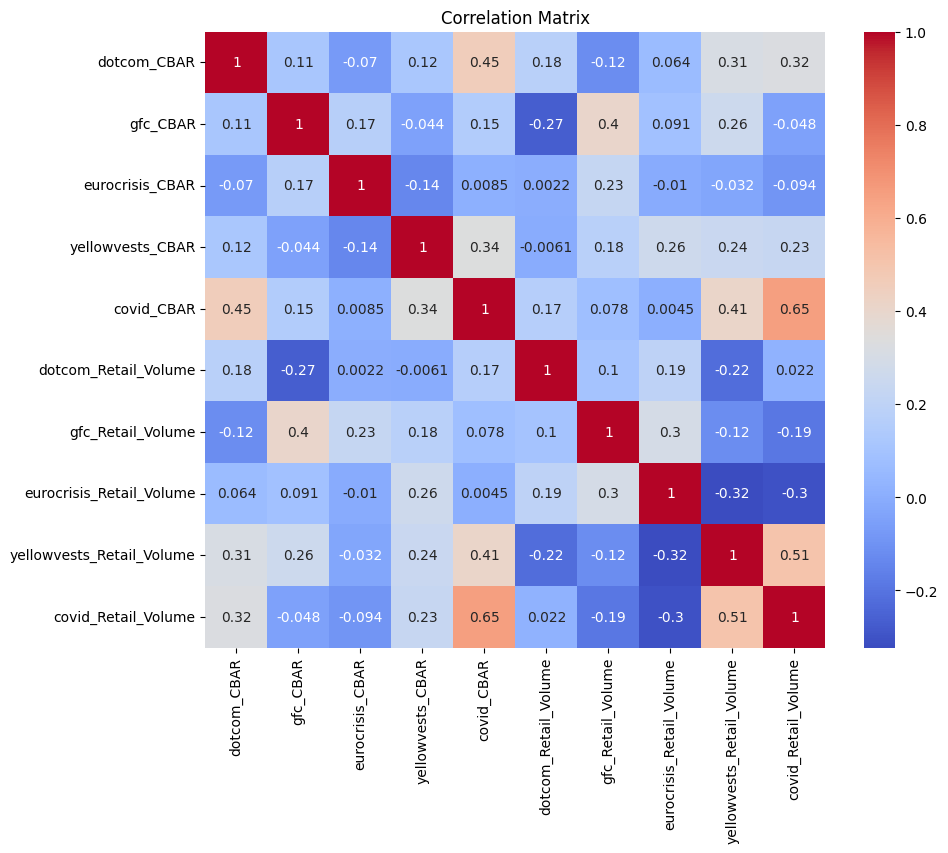

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'housing_df' is the DataFrame containing the data
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(crysis_periods_data("Retail_Volume","CBAR",df_stationary).corr("spearman"), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [104]:
re_cbr = crysis_periods_data("Retail_Volume","CBAR",df_stationary).dropna()

Processing crisis period: dotcom from 2000-01
Processing crisis period: gfc from 2007-10
Processing crisis period: eurocrisis from 2010-01
Processing crisis period: yellowvests from 2018-11
Processing crisis period: covid from 2020-03


In [105]:
re_cbr.columns

Index(['dotcom_CBAR', 'gfc_CBAR', 'eurocrisis_CBAR', 'yellowvests_CBAR',
       'covid_CBAR', 'dotcom_Retail_Volume', 'gfc_Retail_Volume',
       'eurocrisis_Retail_Volume', 'yellowvests_Retail_Volume',
       'covid_Retail_Volume'],
      dtype='object')

<Axes: >

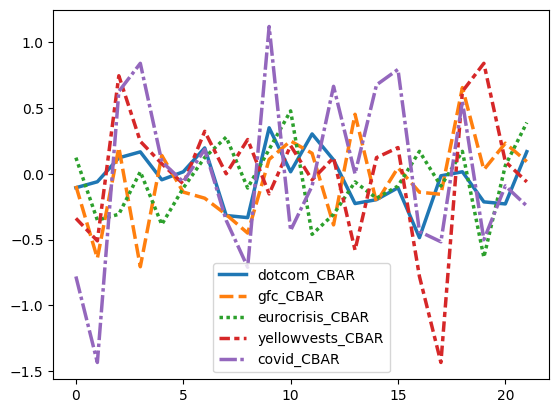

In [106]:
sns.lineplot(data=re_cbr[['dotcom_CBAR', 'gfc_CBAR', 'eurocrisis_CBAR', 'yellowvests_CBAR',
       'covid_CBAR']], palette="tab10", linewidth=2.5)

<Axes: >

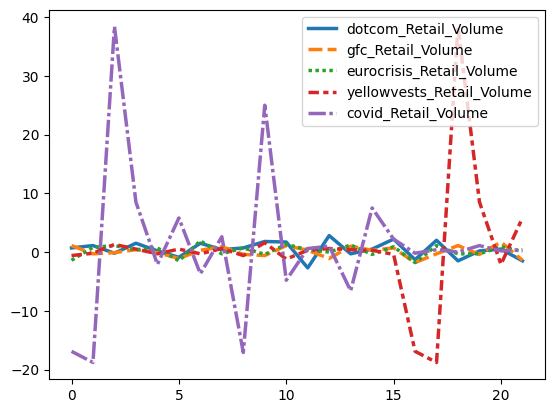

In [107]:
sns.lineplot(data=re_cbr[['dotcom_Retail_Volume', 'gfc_Retail_Volume',
       'eurocrisis_Retail_Volume', 'yellowvests_Retail_Volume',
       'covid_Retail_Volume']], palette="tab10", linewidth=2.5)

In [108]:
ccf(re_cbr["covid_Retail_Volume"],re_cbr["covid_CBAR"])

array([ 0.70898169, -0.35118863, -0.27989226,  0.05526621, -0.16393789,
        0.02178406,  0.06496526,  0.25434018, -0.21645814, -0.12281275,
        0.00518818,  0.00922891,  0.20581398, -0.04150023, -0.13215559,
       -0.00874481,  0.02738476,  0.03344097, -0.0108733 ,  0.03497363,
        0.10749049,  0.06840783])

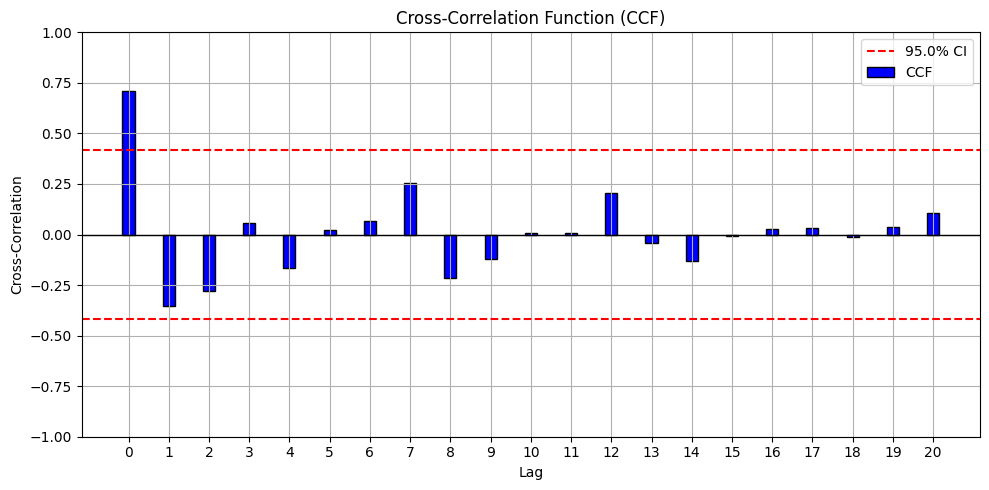

In [109]:
utils.ccf_plot(re_cbr["covid_Retail_Volume"],re_cbr["covid_CBAR"],nlags=21)


Processing crisis period: dotcom from 2000-01
Processing crisis period: gfc from 2007-10
Processing crisis period: eurocrisis from 2010-01
Processing crisis period: yellowvests from 2018-11
Processing crisis period: covid from 2020-03


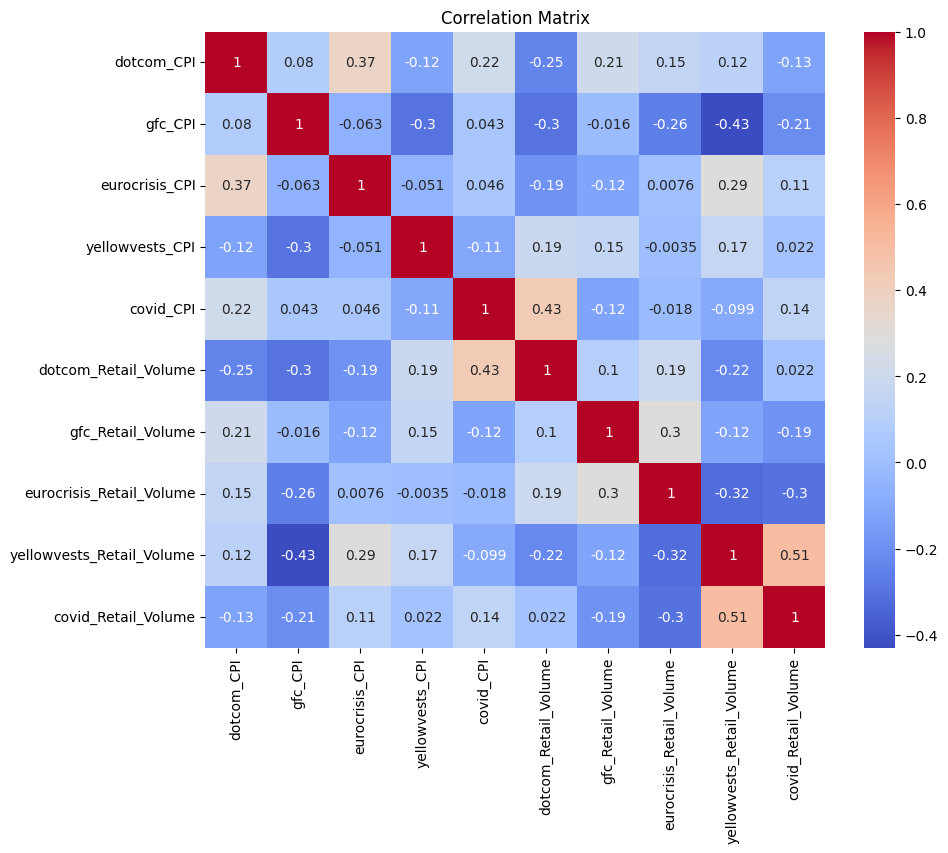

In [110]:
plt.figure(figsize=(10, 8))
sns.heatmap(crysis_periods_data("Retail_Volume","CPI",df_stationary).corr("spearman"), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Processing crisis period: dotcom from 2000-01
Processing crisis period: gfc from 2007-10
Processing crisis period: eurocrisis from 2010-01
Processing crisis period: yellowvests from 2018-11
Processing crisis period: covid from 2020-03


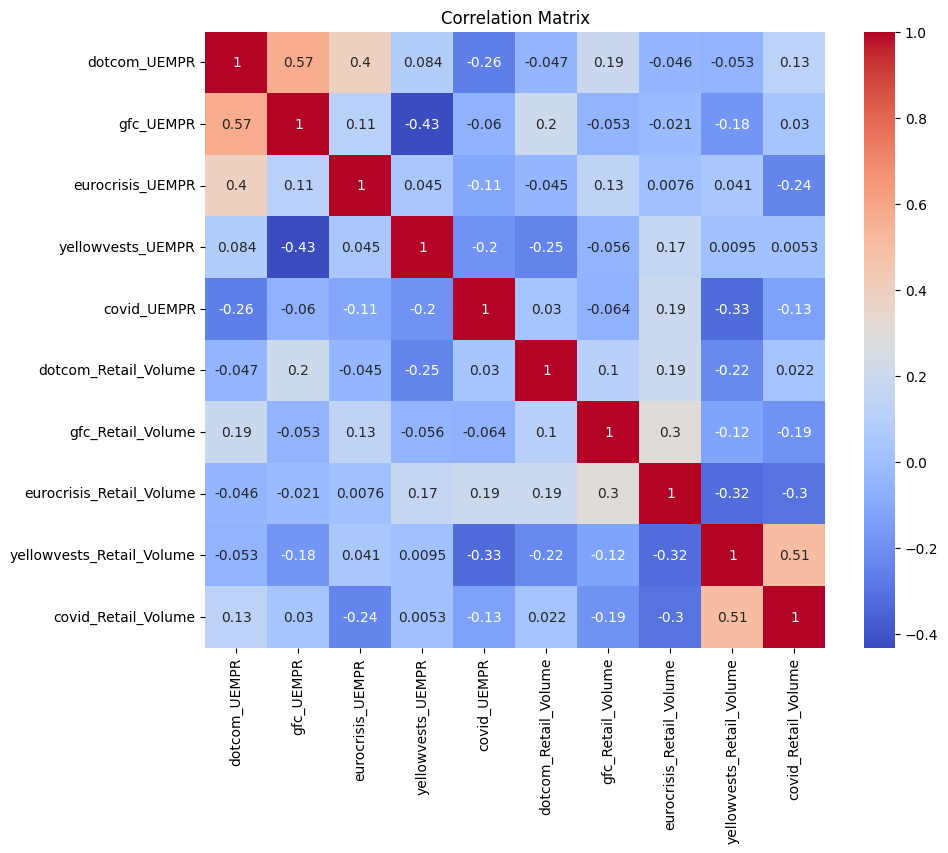

In [111]:
plt.figure(figsize=(10, 8))
sns.heatmap(crysis_periods_data("Retail_Volume","UEMPR",df_stationary).corr("spearman"), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Processing crisis period: dotcom from 2000-01
Processing crisis period: gfc from 2007-10
Processing crisis period: eurocrisis from 2010-01
Processing crisis period: yellowvests from 2018-11
Processing crisis period: covid from 2020-03


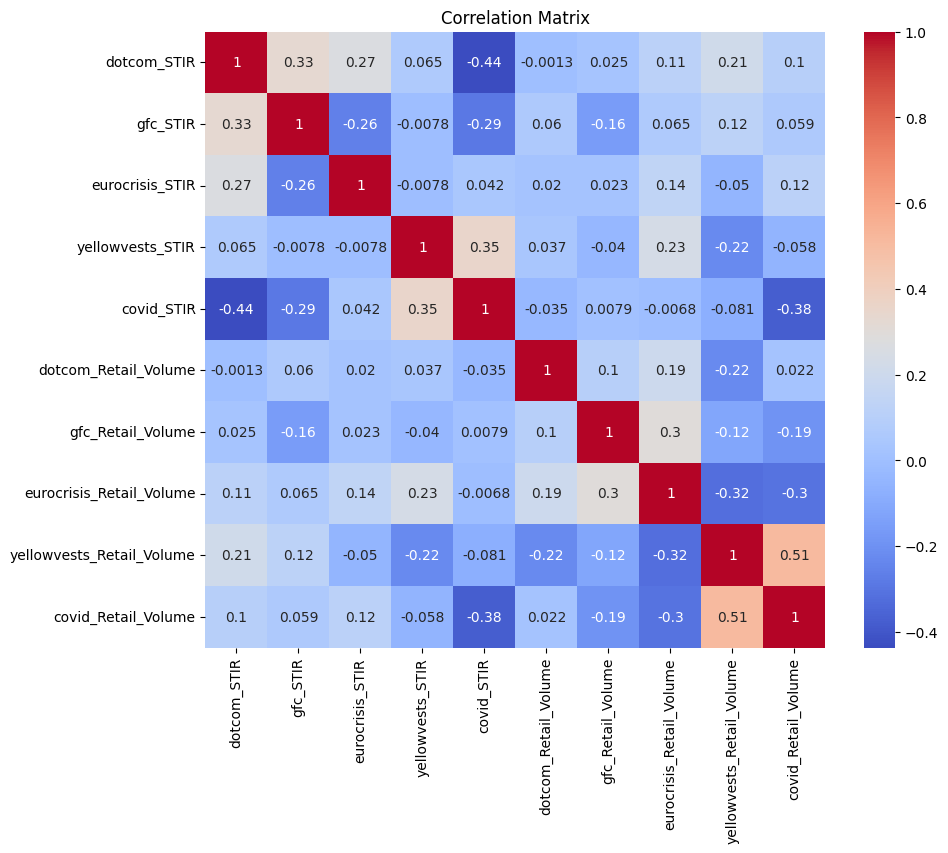

In [112]:
plt.figure(figsize=(10, 8))
sns.heatmap(crysis_periods_data("Retail_Volume","STIR",df_stationary).corr("spearman"), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Processing crisis period: dotcom from 2000-01
Processing crisis period: gfc from 2007-10
Processing crisis period: eurocrisis from 2010-01
Processing crisis period: yellowvests from 2018-11
Processing crisis period: covid from 2020-03


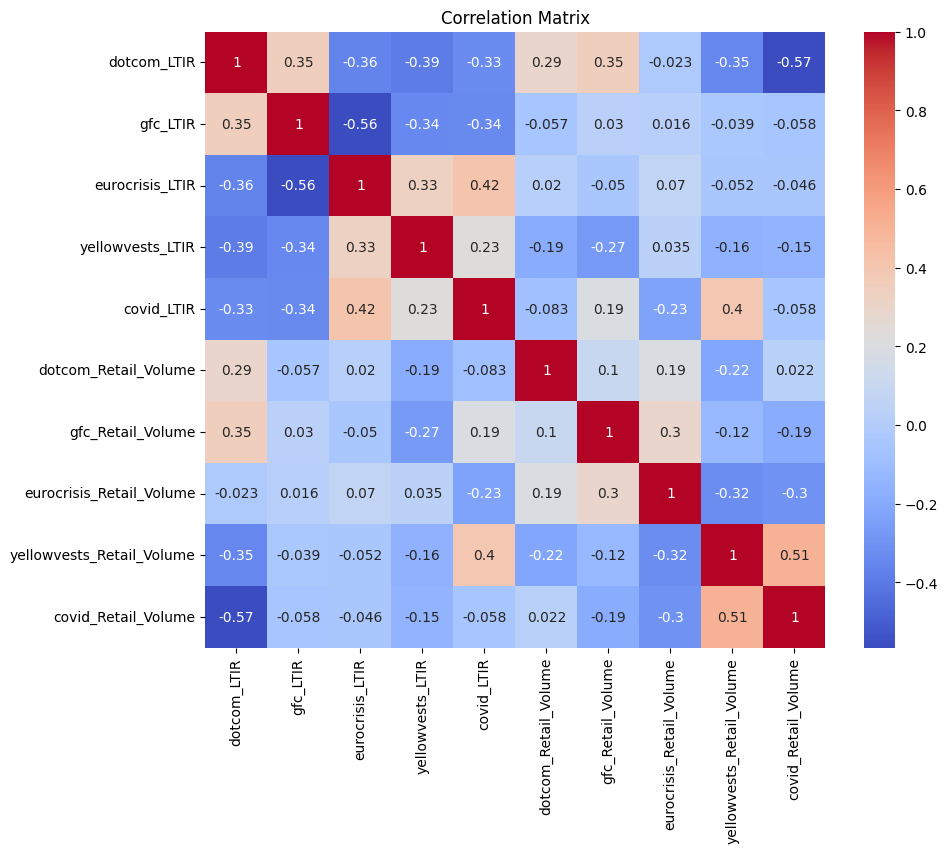

In [113]:
plt.figure(figsize=(10, 8))
sns.heatmap(crysis_periods_data("Retail_Volume","LTIR",df_stationary).corr("spearman"), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Processing crisis period: dotcom from 2000-01
Processing crisis period: gfc from 2007-10
Processing crisis period: eurocrisis from 2010-01
Processing crisis period: yellowvests from 2018-11
Processing crisis period: covid from 2020-03


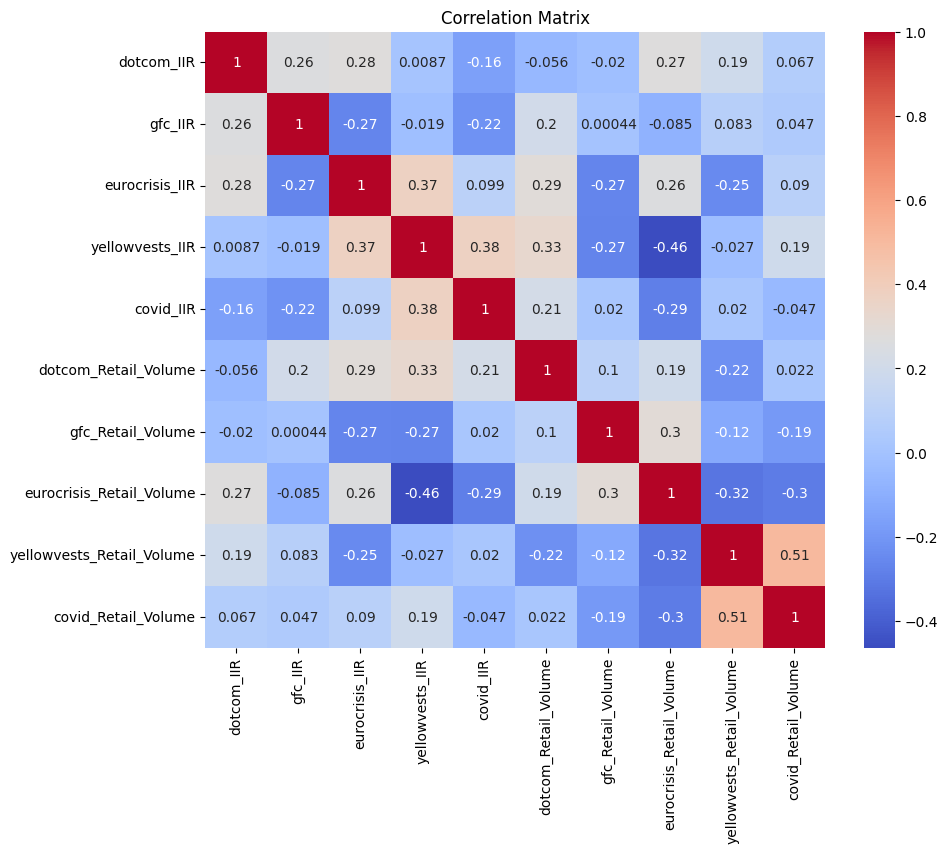

In [114]:
plt.figure(figsize=(10, 8))
sns.heatmap(crysis_periods_data("Retail_Volume","IIR",df_stationary).corr("spearman"), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## PCCF

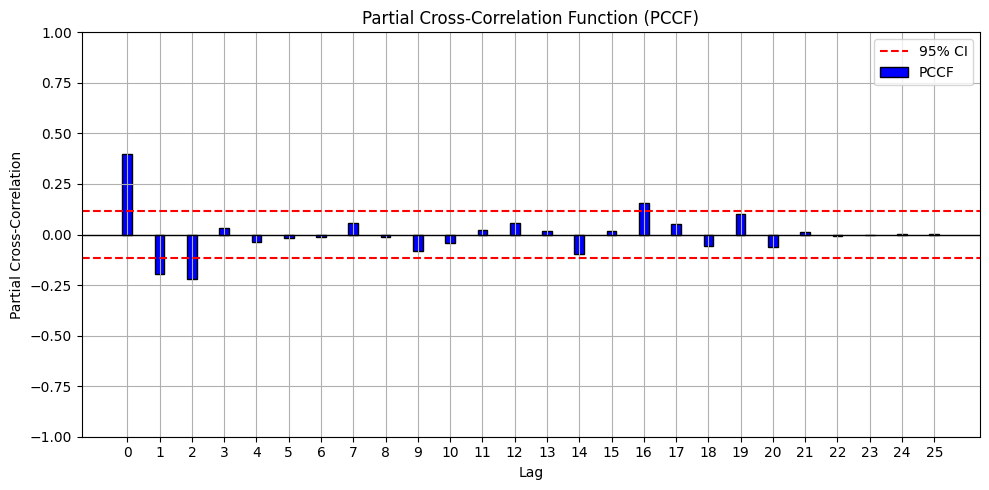

In [115]:
utils.pccf_plot(df_stationary["Retail_Volume"],df_stationary['CBAR'],nlags=25)

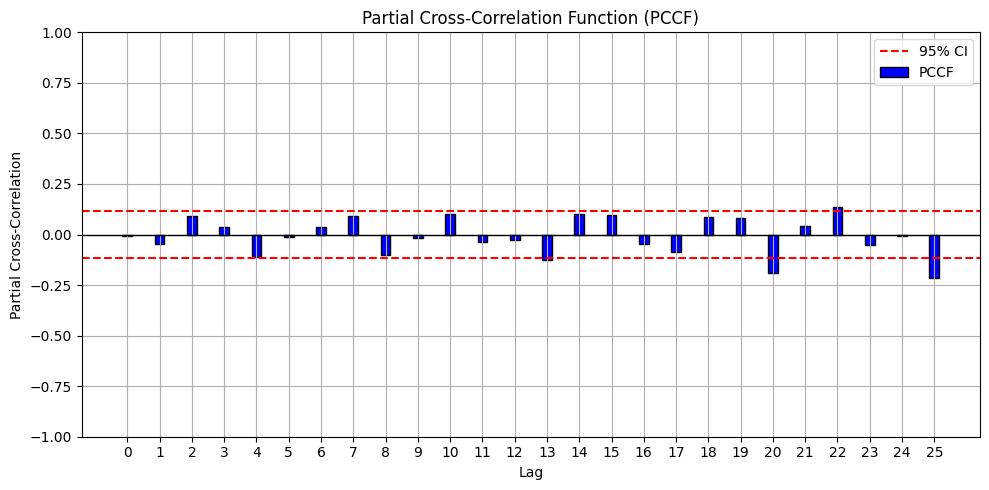

In [116]:
utils.pccf_plot(df_stationary["Retail_Volume"],df_stationary["CPI"],nlags=25)

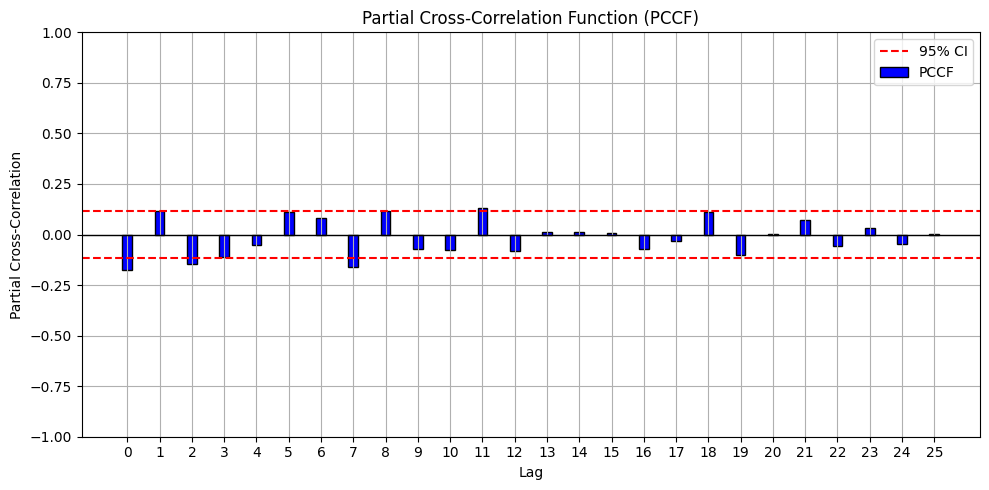

In [117]:
utils.pccf_plot(df_stationary["Retail_Volume"],df_stationary["UEMPR"],nlags=25)

# **Feature importance analysis**

In [118]:
reg_data = df_stationary.copy()
reg_data

,Retail_Volume,CBAR,CPI,LTIR,STIR,IIR,UEMPR,POP_y
DATE,,,,,,,,
1999-03,0.8,-0.182699,-0.1,0.1990,-0.046704,-0.192800,-0.2,0.000573
1999-04,-0.4,-0.091516,0.0,-0.1474,-0.350241,-0.216100,-0.1,0.000573
1999-05,0.7,0.030533,-0.3,0.1793,-0.117503,-0.158100,-0.2,0.000573
1999-06,0.0,0.137358,0.0,0.3207,0.047730,0.012200,-0.1,0.000572
1999-07,0.9,0.243858,-0.3,0.3327,0.049773,-0.042300,-0.1,0.000572
...,...,...,...,...,...,...,...,...
2021-08,0.4,-0.517331,0.6,-0.1100,-0.002773,-0.001578,0.0,0.000272
2021-09,0.0,0.550611,-0.9,0.1600,0.002545,-0.001260,-0.2,0.000272
2021-10,1.1,-0.501962,0.6,0.1600,-0.004764,-0.001053,-0.2,0.000272


### ANOVA

In [119]:
print(reg_data.isnull().sum())

Retail_Volume    0
CBAR             0
CPI              0
LTIR             0
STIR             0
IIR              0
UEMPR            0
POP_y            0
dtype: int64


Only CBAR has a correlation

In [120]:
correlation_matrix = reg_data.corr()
print(correlation_matrix['Retail_Volume'])

Retail_Volume    1.000000
CBAR             0.399043
CPI             -0.006936
LTIR            -0.015784
STIR            -0.013810
IIR              0.006527
UEMPR           -0.177729
POP_y           -0.013845
Name: Retail_Volume, dtype: float64


error interval?
farklı zaman pencerelerinde hesapla ve t teste at

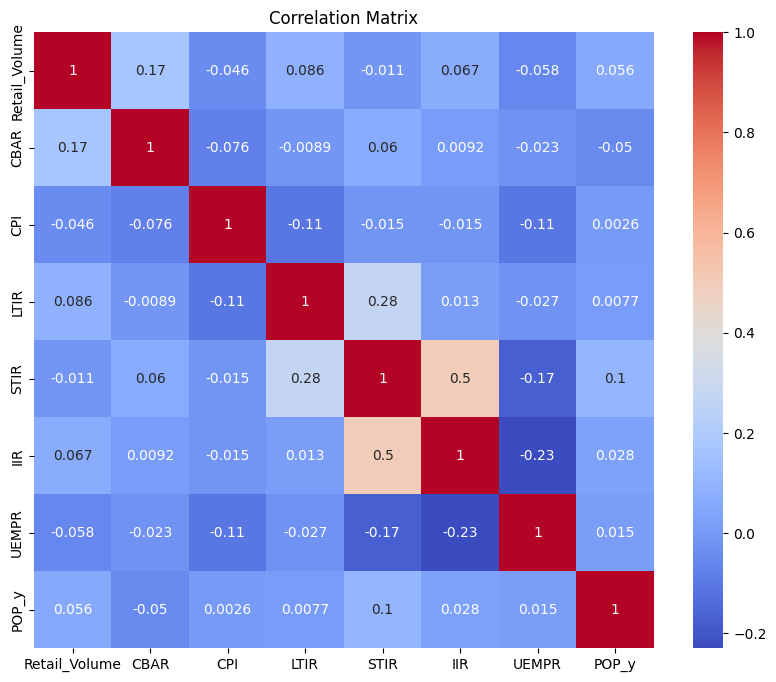

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'housing_df' is the DataFrame containing the data
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(reg_data.corr("spearman"), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### multicolinearity

When Ri2 is equal to 0, and therefore, when VIF or tolerance is equal to 1, the ith independent variable is not correlated to the remaining ones, meaning that multicollinearity does not exist.

1. In general terms,
    - VIF equal to 1 = variables are not correlated
    - VIF between 1 and 5 = variables are moderately correlated 
    - VIF greater than 5 = variables are highly correlated

2. The higher the VIF, the higher the possibility that multicollinearity exists, and further research is required. When VIF is higher than 10, there is significant multicollinearity that needs to be corrected.

This output shows the VIF value for each predictor variable, indicating multicollinearity levels in the dataset. The const row represents the intercept term, with a VIF close to 1, meaning it has no multicollinearity. Among the predictor variables, Product_range has the highest VIF (5.94), which suggests that it needs corrective measures. All the other predictors have VIF values below 3, indicating low multicollinearity. 



In [65]:
reg_data.columns

Index(['Retail_Volume', 'CBAR', 'CPI', 'LTIR', 'STIR', 'IIR', 'UEMPR',
       'POP_y'],
      dtype='object')

In [66]:
from sklearn.preprocessing import StandardScaler

selected_features = [ 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR',"POP_y"]
X = reg_data[selected_features]
y = reg_data['Retail_Volume']


# Initialize the StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

# Print the scaled data
print(X_scaled)

[[-2.00720571e-01  1.35412205e+00 -2.34287607e-01 ... -5.74798836e-01
  -1.17844272e+00  1.08796032e+00]
 [ 1.47588655e-03 -8.46125468e-01 -2.37049480e+00 ... -2.84364672e-01
  -5.35228964e-01  1.08552197e+00]
 [-6.05113486e-01  1.22899250e+00 -7.32550860e-01 ...  1.04389980e-01
  -1.17844272e+00  1.08308641e+00]
 ...
 [ 1.21465463e+00  1.10640365e+00  6.08734975e-02 ... -1.59172139e+00
  -1.17844272e+00 -1.14626812e+00]
 [ 1.47588655e-03 -5.45052338e-01 -2.91388899e-02 ... -2.85033152e-01
   1.07984791e-01 -1.14681817e+00]
 [-4.02917029e-01 -2.27464649e-01 -8.29880533e-03 ... -7.72694656e-01
  -5.35228964e-01 -1.14736792e+00]]


You will use Standardization to ensure all features are on the same scale, improving model performance and comparability.



In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
import pandas as pd



# Add intercept after scaling
X = add_constant(X_scaled)

# Calculate VIF
vif = pd.DataFrame()
vif['Variable'] = ['const'] + selected_features
vif['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif


,Variable,VIF
0,const,1.000000
1,CPI,1.022851
2,LTIR,1.107524
3,STIR,2.120662
4,IIR,1.964446
5,CBAR,1.009857
6,UEMPR,1.076672
7,POP_y,1.003783


#### Model

**Mean Squared Error (MSE):** The MSE measures the average squared difference between the predicted and actual values of the target variable. A lower MSE indicates better model performance, as it means the model is making more accurate predictions

**R-squared (R2):**  R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, where 1 is perfect prediction and 0 indicates no linear relationship



In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns




X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# The 'LinearRegression' model is initialized and fitted to the training data.
model = LinearRegression()
model.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = model.predict(X_test)


print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Mean Squared Error: 8.651305107515933
R-squared: 0.057274280668768496


In [69]:
# select the best alpha with RidgeCV
from sklearn.linear_model import RidgeCV
alpha_range = 10.**np.arange(-2, 3)
ridgeregcv = RidgeCV(alphas=alpha_range, scoring='neg_mean_squared_error')
ridgeregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = ridgeregcv.predict(X_test)


print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 8.343332035040552
R-squared: 0.09083385725008353


In [70]:
# The 'LinearRegression' model is initialized and fitted to the training data.
from sklearn.linear_model import LassoCV
lassoregcv = LassoCV(n_alphas=100, random_state=1)
lassoregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = lassoregcv.predict(X_test)


print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 7.965561021950539
R-squared: 0.13199925895905507


#### Homoscedasticity

**Homoscedasticity**: The variance of residuals is constant across all levels of the independent variables. A residual plot can help verify this.

noktalar restgele dağılmalı

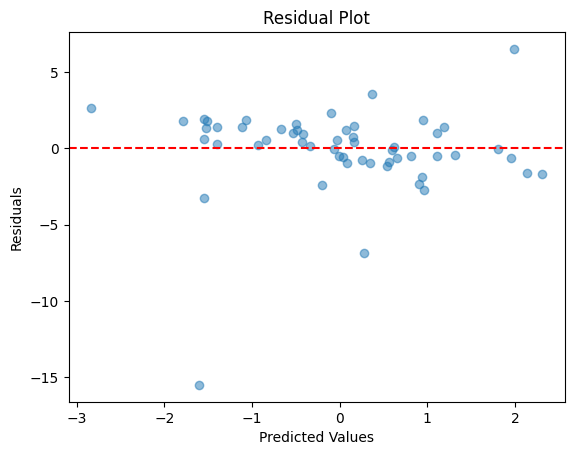

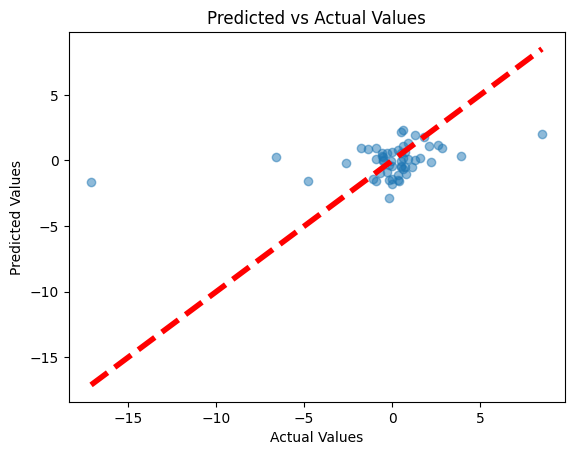

In [71]:
# Residual Plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Predicted vs Actual Plot 
### kontrol ett
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.show()

Truth: mean=-0.062, std=3.029
Pred:  mean=-0.001, std=1.114


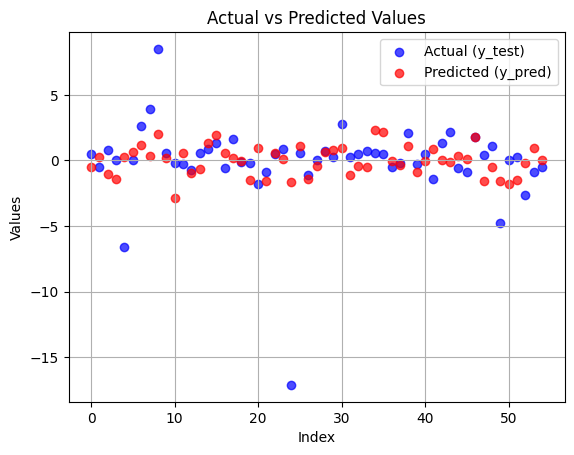

Pearson's correlation: 0.364


In [72]:
import numpy as np
from numpy import mean, std, min as np_min, max as np_max
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

# Descriptive stats
print(f'Truth: mean={mean(y_test):.3f}, std={std(y_test):.3f}')
print(f'Pred:  mean={mean(y_pred):.3f}, std={std(y_pred):.3f}')


# Plot predicted vs actual as separate points along index
plt.scatter(np.arange(len(y_test)), y_test, color='blue', label='Actual (y_test)', alpha=0.7)
plt.scatter(np.arange(len(y_pred)), y_pred, color='red', label='Predicted (y_pred)', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')



plt.legend()
plt.grid(True)
plt.show()

# Pearson correlation
corr, _ = pearsonr(y_test, y_pred)
print(f"Pearson's correlation: {corr:.3f}")

#### ANOVA Tests

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     2.698
Date:                Wed, 23 Apr 2025   Prob (F-statistic):             0.0505
Time:                        10:01:40   Log-Likelihood:                -80.267
No. Observations:                  23   AIC:                             176.5
Df Residuals:                      15   BIC:                             185.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -53.9151     91.978     -0.586      0.5

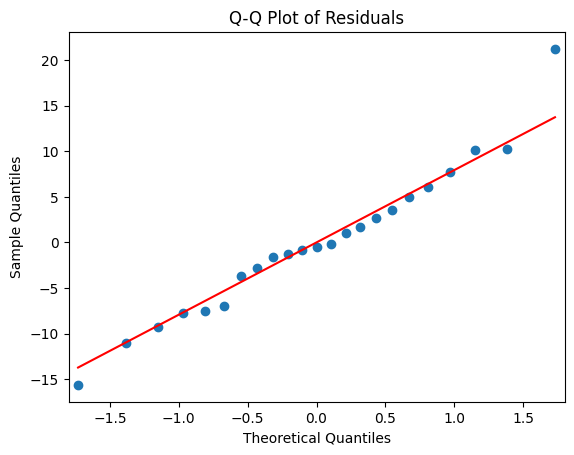

In [73]:


##### lag test
from statsmodels.formula.api import ols
import statsmodels.api as sm

df = reg_data.copy()
df['CPI'] = df['CPI'].shift(251)
df['LTIR'] = df['LTIR'].shift(251)
df['STIR'] = df['STIR'].shift(251)
df['IIR'] = df['IIR'].shift(251)
df['CBAR'] = df['CBAR'].shift(251)
df['UEMPR'] = df['UEMPR'].shift(251)
df['POP_y'] = df['POP_y'].shift(251)

df.dropna(inplace=True)

# Add a constant to the model
model_sm_l = ols('Retail_Volume ~ CPI + UEMPR + CBAR + POP_y + LTIR + STIR + IIR ', data=df).fit()
print(model_sm_l.summary())

# Q-Q Plot for residuals
sm.qqplot(model_sm_l.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

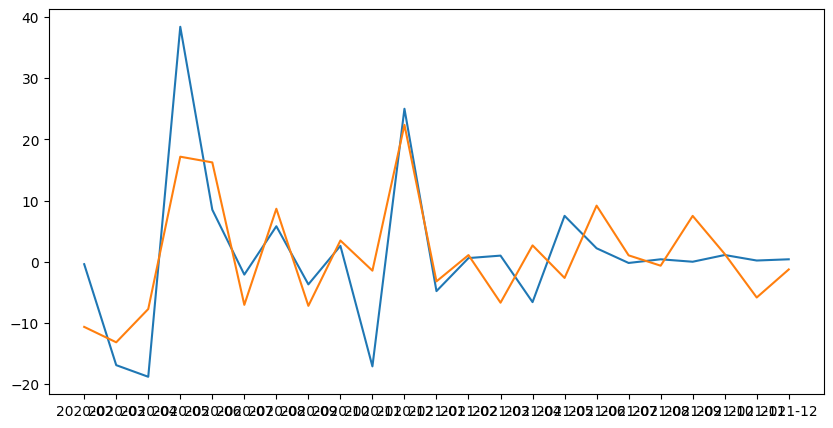

In [74]:
plt.figure(figsize=(10, 5))

plt.plot(df["Retail_Volume"], label='Actual')
plt.plot(model_sm_l.predict(df), label='Predicted')

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     3.114
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           3.37e-11
Time:                        10:01:40   Log-Likelihood:                -563.06
No. Observations:                 274   AIC:                             1382.
Df Residuals:                     146   BIC:                             1845.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

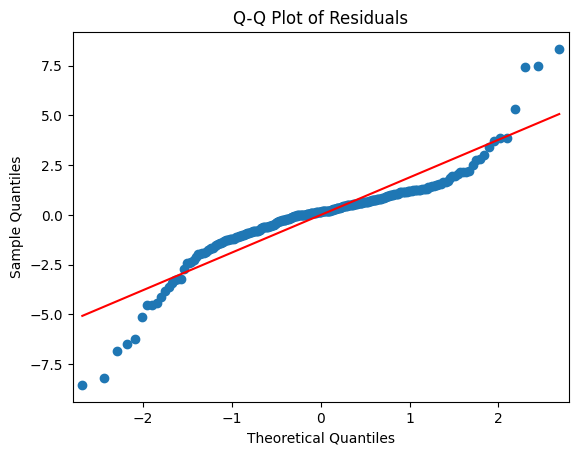

In [75]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Add a constant to the model
model_sm = ols('Retail_Volume ~ CPI* LTIR * STIR * IIR * CBAR * UEMPR * POP_y ', data=reg_data).fit()
print(model_sm.summary())

# Q-Q Plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [76]:
import statsmodels.api as sm
# Assume `results` is your RegressionResultsWrapper object
conf_int = model_sm.conf_int(alpha=0.05)  # 95% confidence interval
conf_int.columns = ['0.025', '0.975']    # Rename columns for clarity
conf_int['coefficient'] = model_sm.params  # Add coefficients
conf_int['P>|t|'] = model_sm.pvalues  # Add p-values

# Combine with variable names (index)
summary_df = conf_int[['coefficient', '0.025', '0.975', 'P>|t|']]

# Filter significant coefficients (P>|t| < 0.05)
significant_coef = summary_df[summary_df['P>|t|'] < 0.05]


In [77]:
significant_coef

,coefficient,0.025,0.975,P>|t|
LTIR:STIR:CBAR,1.728638e+03,4.065992e+02,3.050677e+03,1.074190e-02
CPI:LTIR:UEMPR,-3.218996e+02,-6.211707e+02,-2.262853e+01,3.520414e-02
CPI:STIR:UEMPR,1.439789e+03,2.980456e+01,2.849773e+03,4.541014e-02
LTIR:STIR:UEMPR,4.587795e+03,1.327856e+03,7.847734e+03,6.127820e-03
CBAR:UEMPR,-1.555615e+02,-2.098823e+02,-1.012406e+02,7.766504e-08
STIR:CBAR:UEMPR,-1.629329e+03,-3.128524e+03,-1.301335e+02,3.337220e-02
CPI:IIR:CBAR:UEMPR,7.010521e+03,3.134309e+02,1.370761e+04,4.032454e-02
LTIR:STIR:CBAR:POP_y,-3.894787e+06,-6.775114e+06,-1.014460e+06,8.387047e-03
CPI:LTIR:UEMPR:POP_y,9.561620e+05,1.536872e+05,1.758637e+06,1.986129e-02
LTIR:STIR:UEMPR:POP_y,-8.157491e+06,-1.432958e+07,-1.985405e+06,9.939795e-03


In [78]:
anova_table = sm.stats.anova_lm(model_sm, typ=2)
anova_table = anova_table[anova_table["PR(>F)"] < 0.05].sort_values(by="sum_sq", ascending=False)
anova_table

,sum_sq,df,F,PR(>F)
CBAR:UEMPR,639.272159,1.0,95.462396,1.163842e-17
CBAR,512.166380,1.0,76.481713,4.905999e-15
UEMPR,151.822816,1.0,22.671674,4.584343e-06
STIR:CBAR:UEMPR,117.652564,1.0,17.569036,4.779595e-05
STIR:CBAR:UEMPR:POP_y,86.426612,1.0,12.906070,4.468865e-04
LTIR:STIR:CBAR:POP_y,79.571475,1.0,11.882394,7.404776e-04
CBAR:UEMPR:POP_y,79.014952,1.0,11.799289,7.716628e-04
CPI:UEMPR,48.259018,1.0,7.206510,8.103996e-03
CBAR:POP_y,42.692464,1.0,6.375258,1.264055e-02
STIR:UEMPR,38.242803,1.0,5.710791,1.813727e-02


In [79]:
test_a = significant_coef.index.tolist()
test_a


['LTIR:STIR:CBAR',
 'CPI:LTIR:UEMPR',
 'CPI:STIR:UEMPR',
 'LTIR:STIR:UEMPR',
 'CBAR:UEMPR',
 'STIR:CBAR:UEMPR',
 'CPI:IIR:CBAR:UEMPR',
 'LTIR:STIR:CBAR:POP_y',
 'CPI:LTIR:UEMPR:POP_y',
 'LTIR:STIR:UEMPR:POP_y',
 'CBAR:UEMPR:POP_y']

In [80]:
# Step 1: Sort ANOVA table and get top 30 features
test_b = anova_table.sort_values("sum_sq", ascending=False).index.tolist()
# Step 2: Remove 'Residual' if it's present (not a feature)
test_b = [feat for feat in test_b if feat.lower() != 'residual']
test_b

['CBAR:UEMPR',
 'CBAR',
 'UEMPR',
 'STIR:CBAR:UEMPR',
 'STIR:CBAR:UEMPR:POP_y',
 'LTIR:STIR:CBAR:POP_y',
 'CBAR:UEMPR:POP_y',
 'CPI:UEMPR',
 'CBAR:POP_y',
 'STIR:UEMPR',
 'STIR:POP_y',
 'LTIR:STIR:UEMPR:POP_y',
 'LTIR:CBAR:UEMPR',
 'CPI:IIR:CBAR:UEMPR:POP_y',
 'CPI:LTIR:CBAR:UEMPR:POP_y',
 'LTIR:IIR']

In [81]:
test_c = list(set(test_a + test_b))
test_c

['CPI:UEMPR',
 'CPI:IIR:CBAR:UEMPR',
 'CBAR:POP_y',
 'CBAR:UEMPR:POP_y',
 'CPI:STIR:UEMPR',
 'LTIR:IIR',
 'LTIR:CBAR:UEMPR',
 'STIR:CBAR:UEMPR',
 'UEMPR',
 'STIR:UEMPR',
 'CPI:LTIR:UEMPR',
 'LTIR:STIR:UEMPR',
 'LTIR:STIR:CBAR',
 'LTIR:STIR:CBAR:POP_y',
 'LTIR:STIR:UEMPR:POP_y',
 'CPI:IIR:CBAR:UEMPR:POP_y',
 'CBAR:UEMPR',
 'CBAR',
 'STIR:CBAR:UEMPR:POP_y',
 'STIR:POP_y',
 'CPI:LTIR:UEMPR:POP_y',
 'CPI:LTIR:CBAR:UEMPR:POP_y']

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     13.20
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           1.07e-30
Time:                        10:01:40   Log-Likelihood:                -637.29
No. Observations:                 274   AIC:                             1321.
Df Residuals:                     251   BIC:                             1404.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

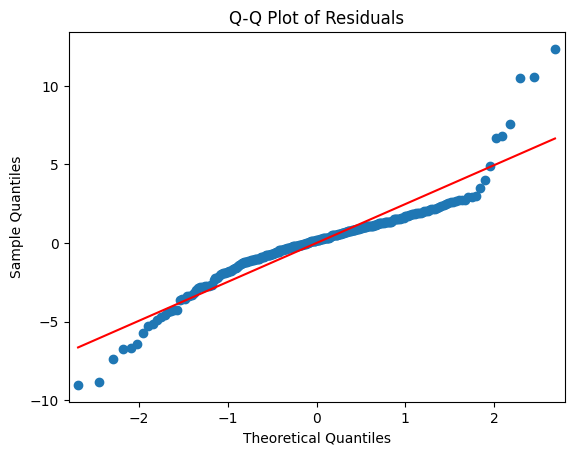

In [82]:
from statsmodels.formula.api import ols
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Step 3: Build formula string
formula = 'Retail_Volume ~ ' + ' + '.join(test_c)

# Step 4: Fit OLS model
model_sm = ols(formula, data=reg_data).fit()
print(model_sm.summary())

# Step 5: Q-Q plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [83]:
reg_data["Retail_Volume"]

DATE
1999-03    0.8
1999-04   -0.4
1999-05    0.7
1999-06    0.0
1999-07    0.9
          ... 
2021-08    0.4
2021-09    0.0
2021-10    1.1
2021-11    0.2
2021-12    0.4
Name: Retail_Volume, Length: 274, dtype: float64

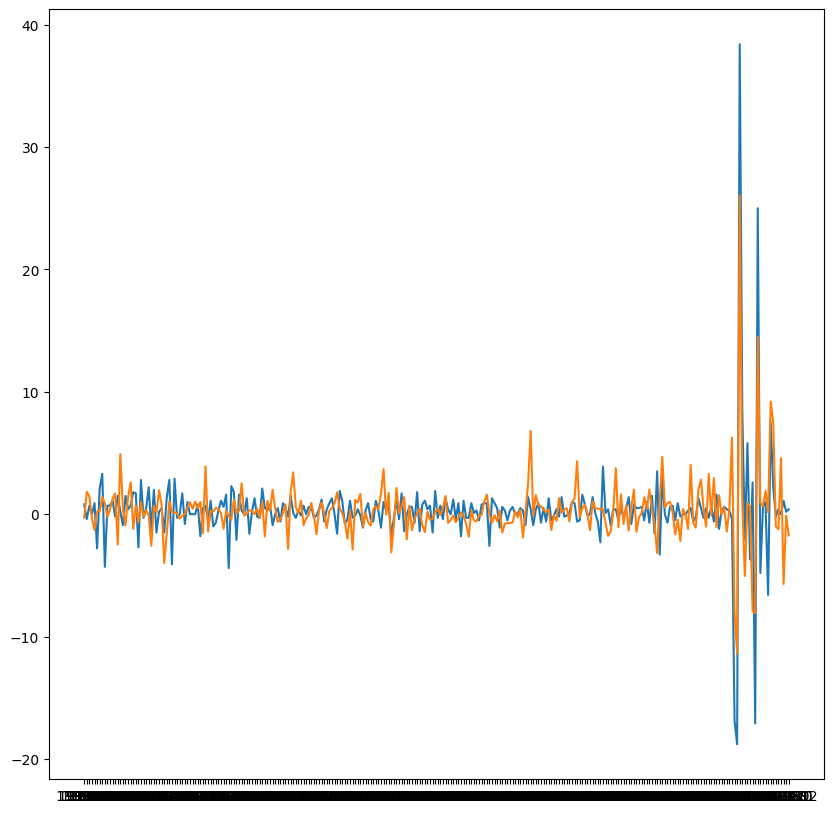

In [84]:
plt.figure(figsize=(10, 10))

plt.plot(reg_data["Retail_Volume"], label='Actual')
plt.plot(model_sm.predict(reg_data), label='Predicted')

In [85]:
df_filled.columns

Index(['GEO_x', 'Retail_Volume', 'CPI', 'GEO_y', 'LTIR', 'STIR', 'IIR', 'CBAR',
       'UEMPR', 'POP_y'],
      dtype='object')

In [86]:
def combined_df(combinations,data):
    # Sütunları oluşturma ve çarpma işlemi
    df = data.copy()
    for comb in combinations:
        columns = comb.split(':')  # ':' ile ayırarak ilgili sütunları al
        product = df[columns[0]]  # ilk sütun ile başla
        for col in columns[1:]:   # geri kalan sütunlarla çarp
            product *= df[col]
        df[comb] = product  # Yeni sütunu DataFrame'e eklw

    return df[combinations]

In [87]:
test_a

['LTIR:STIR:CBAR',
 'CPI:LTIR:UEMPR',
 'CPI:STIR:UEMPR',
 'LTIR:STIR:UEMPR',
 'CBAR:UEMPR',
 'STIR:CBAR:UEMPR',
 'CPI:IIR:CBAR:UEMPR',
 'LTIR:STIR:CBAR:POP_y',
 'CPI:LTIR:UEMPR:POP_y',
 'LTIR:STIR:UEMPR:POP_y',
 'CBAR:UEMPR:POP_y']

In [88]:
combined_df(test_a,reg_data)

,LTIR:STIR:CBAR,CPI:LTIR:UEMPR,CPI:STIR:UEMPR,LTIR:STIR:UEMPR,CBAR:UEMPR,STIR:CBAR:UEMPR,CPI:IIR:CBAR:UEMPR,LTIR:STIR:CBAR:POP_y,CPI:LTIR:UEMPR:POP_y,LTIR:STIR:UEMPR:POP_y,CBAR:UEMPR:POP_y
DATE,,,,,,,,,,,
1999-03,0.001698,0.000034,3.172170e-07,1.586085e-05,0.036540,0.000341,4.469497e-10,1.134263e-13,-5.814005e-27,-4.439826e-21,-4.190522e-06
1999-04,-0.004725,0.000000,0.000000e+00,-1.654744e-04,0.009152,0.000321,0.000000e+00,-2.781765e-13,0.000000e+00,5.109879e-21,-5.244732e-07
1999-05,-0.000643,-0.000039,-9.070583e-07,-1.511764e-05,-0.006107,-0.000144,1.751470e-10,-7.588386e-15,1.522500e-28,-1.247496e-22,6.995372e-07
1999-06,0.002103,-0.000000,0.000000e+00,-1.003546e-05,-0.013736,0.000066,0.000000e+00,5.173284e-15,-0.000000e+00,-1.941510e-23,7.862885e-07
1999-07,0.004038,0.000121,-6.029742e-07,-2.009914e-05,-0.024386,0.000121,6.219795e-11,3.403480e-14,-1.211092e-28,-2.363371e-22,1.395131e-06
...,...,...,...,...,...,...,...,...,...,...,...
2021-08,-0.000158,-0.000000,0.000000e+00,0.000000e+00,-0.000000,0.000000,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
2021-09,0.000224,0.000040,-2.055007e-08,-1.141671e-07,-0.110122,0.000056,5.704615e-13,1.919870e-16,-5.966325e-33,-5.863519e-25,5.999062e-06
2021-10,0.000383,-0.000046,-4.374861e-08,3.645717e-07,0.100393,0.000096,-9.245228e-13,9.533597e-16,4.800260e-32,-4.966602e-24,-5.467536e-06


In [89]:
# The 'LinearRegression' model is initialized and fitted to the training data.
from sklearn.linear_model import LassoCV

X = combined_df(test_a,reg_data)
y = reg_data['Retail_Volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lassoregcv = LassoCV(n_alphas=100, random_state=1)
lassoregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = lassoregcv.predict(X_test)


print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 20.947543324543187
R-squared: -1.2826368511377515


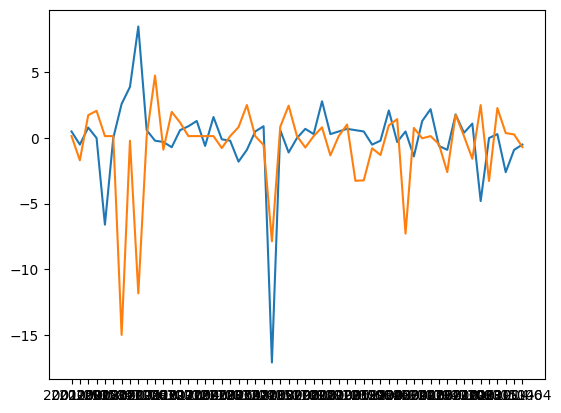

In [90]:

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')


In [91]:

# select the best alpha with RidgeCV
from sklearn.linear_model import RidgeCV

alpha_range = 10.**np.arange(1, 3)
ridgeregcv = RidgeCV(alphas=alpha_range, scoring='neg_mean_squared_error')
ridgeregcv.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = ridgeregcv.predict(X_test)


print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 9.503040924391813
R-squared: -0.035538682307986624


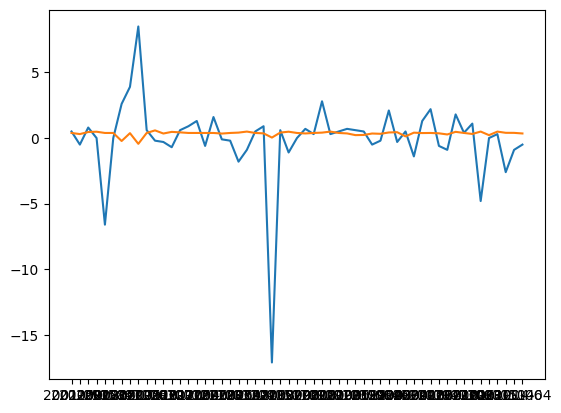

In [92]:

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')


### Permutation importance

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)


result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)


importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)


                  feature  importance_mean  importance_std
3         LTIR:STIR:UEMPR     7.213067e+00    8.645704e-01
7    LTIR:STIR:CBAR:POP_y     4.833867e+00    8.951645e-01
6      CPI:IIR:CBAR:UEMPR     1.610870e+00    3.536511e-01
2          CPI:STIR:UEMPR     1.370987e+00    5.430506e-01
0          LTIR:STIR:CBAR     3.220613e-01    1.352240e-01
10       CBAR:UEMPR:POP_y     2.147129e-01    2.464050e-01
5         STIR:CBAR:UEMPR     2.119250e-02    9.360147e-03
9   LTIR:STIR:UEMPR:POP_y     1.993901e-12    1.182341e-12
8    CPI:LTIR:UEMPR:POP_y     0.000000e+00    0.000000e+00
1          CPI:LTIR:UEMPR    -8.217311e-02    5.159381e-02
4              CBAR:UEMPR    -3.061742e-01    2.287020e-01


In [94]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
7.0105 ± 0.3376,LTIR:STIR:UEMPR
5.2086 ± 0.4198,LTIR:STIR:CBAR:POP_y
1.7188 ± 0.8767,CPI:STIR:UEMPR
1.4110 ± 0.1044,CPI:IIR:CBAR:UEMPR
0.3455 ± 0.1012,CBAR:UEMPR:POP_y
0.2829 ± 0.0478,LTIR:STIR:CBAR
0.0187 ± 0.0087,STIR:CBAR:UEMPR
0.0000 ± 0.0000,LTIR:STIR:UEMPR:POP_y
0 ± 0.0000,CPI:LTIR:UEMPR:POP_y
-0.0598 ± 0.0344,CPI:LTIR:UEMPR


# **Causality**

In [95]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

def plot_granger_causality_pvalues(df, maxlag, variables, alpha=0.05, verbose=False):
    """
    Run grangercausalitytests and plot p-values for each lag.

    Parameters:
    - df: DataFrame with two columns [Y, X] where X is tested as a cause of Y
    - maxlag: maximum lag to test
    - variables: tuple (Y, X) – names of the dependent and independent variables
    - alpha: significance level for rejection
    - verbose: if True, prints full test output
    """
    y_col, x_col = variables
    test_result = grangercausalitytests(df[[y_col, x_col]], maxlag=maxlag, verbose=verbose)

    p_values = []
    for lag in range(1, maxlag + 1):
        p_val = test_result[lag][0]['ssr_ftest'][1]  # extract p-value from F-test
        p_values.append(p_val)

    # Plot p-values
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, maxlag + 1), p_values, color='skyblue')
    plt.axhline(y=alpha, color='red', linestyle='--', label=f'Significance level ({alpha})')
    plt.xticks(range(1, maxlag + 1))
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.title(f"Granger Causality Test p-values: Does {x_col} → {y_col}?")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return p_values


/Users/emirysaglam/GitHub/Bitirme2/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


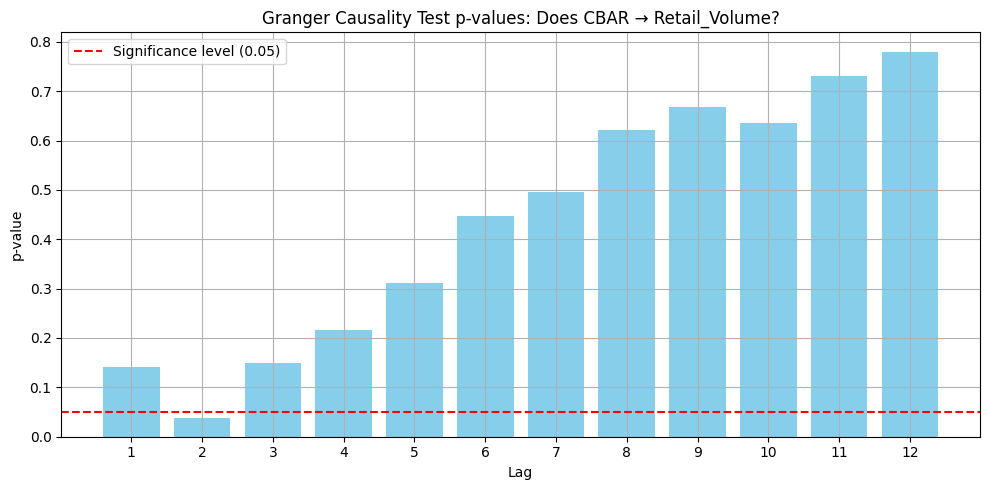

[np.float64(0.14181425757217755),
 np.float64(0.03734895445931497),
 np.float64(0.14917718928801924),
 np.float64(0.21586329923148484),
 np.float64(0.3107596338045549),
 np.float64(0.44740247198495475),
 np.float64(0.4947802887852),
 np.float64(0.6210143143879431),
 np.float64(0.6675990240363378),
 np.float64(0.6358087862976725),
 np.float64(0.7310689145358322),
 np.float64(0.7801036714892943)]

In [96]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

plot_granger_causality_pvalues(df_test, 12, variables=('Retail_Volume','CBAR'))


# **Cointegration**

In [97]:
from statsmodels.tsa.stattools import coint

# Two time series: y and x (non-stationary)
# For example: y = GDP, x = Unemployment Rate
score, pvalue, _ = coint(df_test["Retail_Volume"],df_test["CBAR"])

print("Cointegration Test p-value:", pvalue)

if pvalue < 0.05:
    print("✅ Series are cointegrated.")
else:
    print("❌ No cointegration detected.")


Cointegration Test p-value: 1.03993061540743e-09
✅ Series are cointegrated.


In [98]:
con.close()